# Import libraries

In [ ]:
# Import essential libraries
import os              # OS module for operating system dependent functionality
import time            # Time module for time related functions
import joblib          # Joblib for efficient serialization of large numpy arrays
import pandas as pd    # Pandas for data manipulation and analysis
import numpy as np     # Numpy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting and visualization
from tqdm import tqdm  # Tqdm for progress bar indication

# Import sklearn modules for model building, preprocessing, and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold  # For training-testing split and k-fold cross-validation
from sklearn.preprocessing import LabelEncoder, StandardScaler         # For encoding labels and scaling features
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # RandomForest models for classification and regression

# Import sklearn metrics for performance evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

# Import XGBoost for gradient boosting models
from xgboost import XGBClassifier  # XGBoost classifier

# Import SHAP for model interpretability
import shap  # SHAP for explaining model predictions

# Import KMeans clustering algorithm
from sklearn.cluster import KMeans  # KMeans algorithm for clustering

# Example usage of KMeans for clustering would be added here if needed

# Note:
# Ensure SHAP is installed in your working environment using:
# pip install shap

# Load input csv file(imputed)

In [ ]:
# Load the imputede SV file for model development
file_path = "/content/gossis-1-eicu-only-model-ready.csv" # specify your file path
df_1 = pd.read_csv(file_path)

In [ ]:
df_1.isnull().values.any() # check if any missing
df_clean = df_1.dropna() # remove the rows with missing item(s)
df_clean.isnull().values.any() # check if these rows are removed or not

np.False_

In [ ]:
df_clean.shape # check the size

(130810, 71)

In [ ]:
df_cleaned = df_clean.drop(['patientunitstayid', 'encounter_id', 'partition', 'hospital_death'], axis=1)

In [ ]:
df_cleaned.shape

(130810, 67)

# Data preprocession

In [ ]:
# 1. Find categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# 2. Convert categorical variables to numeric data
df_encoded = df_cleaned.copy()  # Create a copy of the DataFrame to avoid modifying the original data
for col in categorical_cols:
    # Apply LabelEncoder to each categorical column
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# 3. Select features and target
target = "icu_death"  # Specify the target label
# Use list comprehension to select all columns except the target as features
features = [col for col in df_encoded.columns if col != target]

# 4. Extract feature and target values
X = df_encoded[features].values  # Extract the values for input features, used for model training
y = df_encoded[target].values  # Extract the values for the target label

# 5. Normalize the feature data
scaler = StandardScaler()  # Initialize the StandardScaler
X = scaler.fit_transform(X)  # Apply standardization to the feature data

# AUROC, AUPRC visualization

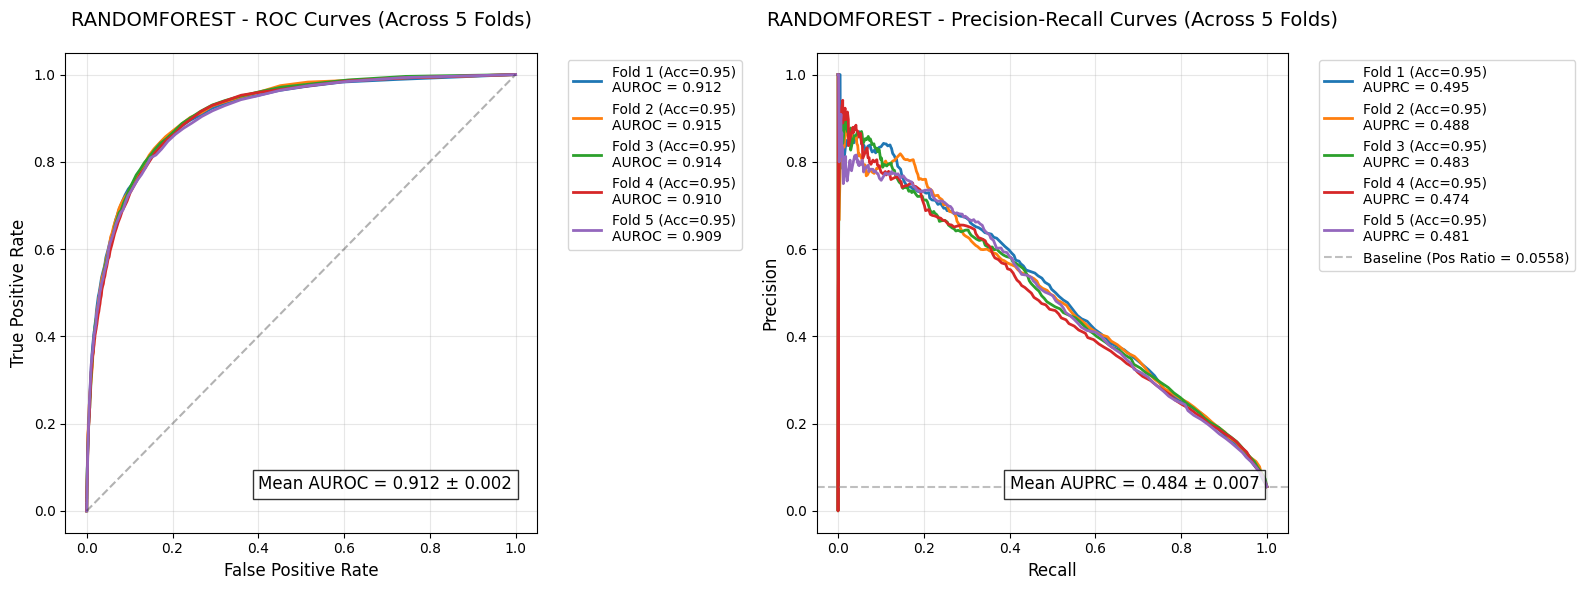

In [ ]:
def plot_model_performance(model_name, X, y, n_splits=5):
    """Plot performance metrics across all folds for a given model using the correct validation splits."""
    # Initialize lists to store metrics for all folds
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []
    all_accuracy = []
    all_auroc = []
    all_auprc = []
    fold_labels = []

    # Initialize cross-validation splitter
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Base folder where models are saved
    save_folder = f'saved_models_{model_name}'

    # Iterate over each fold
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Load model for the current fold
        if model_name == 'xgboost':  # Load XGBoost models
            model_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.json')
            model = XGBClassifier()
            model.load_model(model_path)
        else:  # Load other models (e.g., RandomForest) serialized with joblib
            model_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.pkl')
            model = joblib.load(model_path)

        # Get the correct validation data for this fold
        X_val = X[val_idx]
        y_val = y[val_idx]

        # Get prediction probabilities
        y_pred = model.predict_proba(X_val)

        # Assuming binary classification
        if y_pred.shape[1] == 2:
            y_pred = y_pred[:, 1]

        # Compute metrics
        fpr, tpr, _ = roc_curve(y_val, y_pred)
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        accuracy = accuracy_score(y_val, (y_pred > 0.5).astype(int))
        auroc = roc_auc_score(y_val, y_pred)
        auprc = average_precision_score(y_val, y_pred)

        # Store metrics for this fold
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_precision.append(precision)
        all_recall.append(recall)
        all_accuracy.append(accuracy)
        all_auroc.append(auroc)
        all_auprc.append(auprc)
        fold_labels.append(f'Fold {fold+1} (Acc={accuracy:.2f})')

    # Create figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot ROC curves
    plt.subplot(1, 2, 1)
    for i in range(n_splits):
        plt.plot(all_fpr[i], all_tpr[i],
                 label=f'{fold_labels[i]}\nAUROC = {all_auroc[i]:.3f}',
                 linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name.upper()} - ROC Curves (Across {n_splits} Folds)', fontsize=14, pad=20)

    # Add mean AUROC to the plot
    mean_auroc = np.mean(all_auroc)
    std_auroc = np.std(all_auroc)
    plt.text(0.4, 0.05,
             f'Mean AUROC = {mean_auroc:.3f} ± {std_auroc:.3f}',
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot PR curves
    plt.subplot(1, 2, 2)
    for i in range(n_splits):
        plt.plot(all_recall[i], all_precision[i],
                 label=f'{fold_labels[i]}\nAUPRC = {all_auprc[i]:.3f}',
                 linewidth=2)

    # Add baseline (positive class ratio)
    positive_ratio = np.mean(y)  # Calculate the positive class ratio dynamically
    plt.axhline(y=positive_ratio, color='gray', linestyle='--', alpha=0.5,
                label=f'Baseline (Pos Ratio = {positive_ratio:.4f})')

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name.upper()} - Precision-Recall Curves (Across {n_splits} Folds)', fontsize=14, pad=20)

    # Add mean AUPRC to the plot
    mean_auprc = np.mean(all_auprc)
    std_auprc = np.std(all_auprc)
    plt.text(0.4, 0.05,
             f'Mean AUPRC = {mean_auprc:.3f} ± {std_auprc:.3f}',
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f'{model_name}_performance_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# Usage:
# plot_model_performance('xgboost', X, y)
plot_model_performance('randomforest', X, y)

# XGboost Interpretation


In [ ]:
def calculate_cluster_importance(feature_names, shap_values, num_clusters=20):
    """
    Calculate and visualize the importance of feature clusters.

    """
    # Compute mean absolute SHAP values for each feature
    mean_shap_values = np.abs(shap_values).mean(axis=0)

    # Reshape for clustering
    mean_shap_values = mean_shap_values.reshape(-1, 1)

    # Clustering features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(mean_shap_values)
    feature_clusters = kmeans.labels_

    # Calculate cluster importance by summing SHAP values within each cluster
    cluster_importance = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        cluster_importance[cluster] = mean_shap_values[cluster_indices].sum()

    # Normalize cluster importance
    total_importance = sum(cluster_importance.values())
    for cluster in cluster_importance:
        cluster_importance[cluster] /= total_importance

    # Visualization
    cluster_names = [f'Cluster {i+1}' for i in range(num_clusters)]
    cluster_values = [cluster_importance[i] for i in range(num_clusters)]

    plt.figure(figsize=(10,6))
    plt.barh(cluster_names, cluster_values, color='skyblue')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Clusters')
    plt.title('Feature Cluster Importance')
    plt.show()

    # Print cluster details
    print("Cluster details:")
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        print(f"\nCluster {cluster + 1} features:")
        for idx in cluster_indices:
            print(f"  {feature_names[idx]} (SHAP: {mean_shap_values[idx][0]:.4f})")



【XGBOOST】starting five fold cross validation - 2025-05-21 02:47:21
📊 original data distribution:
  negative: 123510 | positive: 7300
  positive percentage: 5.58%


🔍 per fold result：
  ✅ Fold 1: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 2: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 3: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 4: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 5: training 5.58% positive | validation 5.58% positive | difference: 0.00%

🏋️ training begin XGBOOST model...

🔄 FOLD 1/5 - 02:47:21
  training: 104648 | validation: 26162
  positive percentage in training: 5.58% | positive percentage in validation: 5.58%

⚙️ XGBoost parameter:
  n_estimators=200 | max_depth=6 | lr=0.05
  early_stopping=20 | eval_metric=[logloss, auc, aucpr]

⏳ training process:
[0]	validation_0-logloss:0.24700	validation_0-auc:0.86915	validation_0-

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.19272	validation_0-auc:0.91060	validation_0-aucpr:0.54545	validation_1-logloss:0.19576	validation_1-auc:0.89527	validation_1-aucpr:0.48326
[20]	validation_0-logloss:0.16391	validation_0-auc:0.91771	validation_0-aucpr:0.56612	validation_1-logloss:0.16895	validation_1-auc:0.90040	validation_1-aucpr:0.49785
[30]	validation_0-logloss:0.14680	validation_0-auc:0.92326	validation_0-aucpr:0.58165	validation_1-logloss:0.15396	validation_1-auc:0.90299	validation_1-aucpr:0.50434
[40]	validation_0-logloss:0.13604	validation_0-auc:0.92842	validation_0-aucpr:0.59573	validation_1-logloss:0.14525	validation_1-auc:0.90558	validation_1-aucpr:0.50934
[50]	validation_0-logloss:0.12839	validation_0-auc:0.93383	validation_0-aucpr:0.61222	validation_1-logloss:0.13967	validation_1-auc:0.90932	validation_1-aucpr:0.51687
[60]	validation_0-logloss:0.12290	validation_0-auc:0.93799	validation_0-aucpr:0.62697	validation_1-logloss:0.13607	validation_1-auc:0.91173	validation_1-aucpr:0.5239

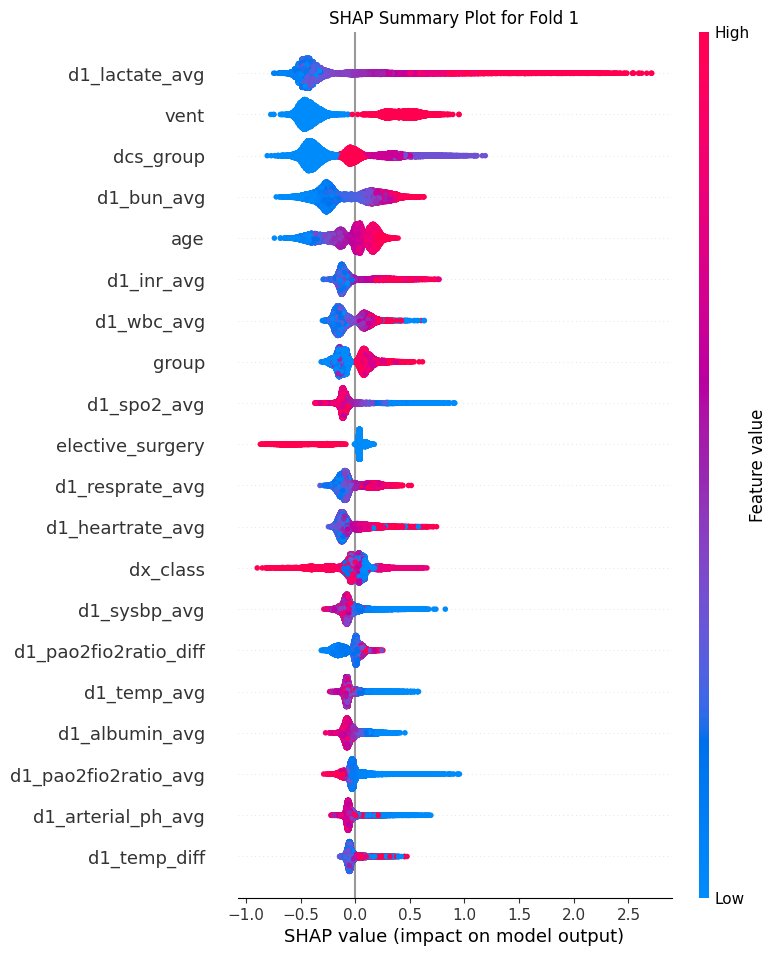

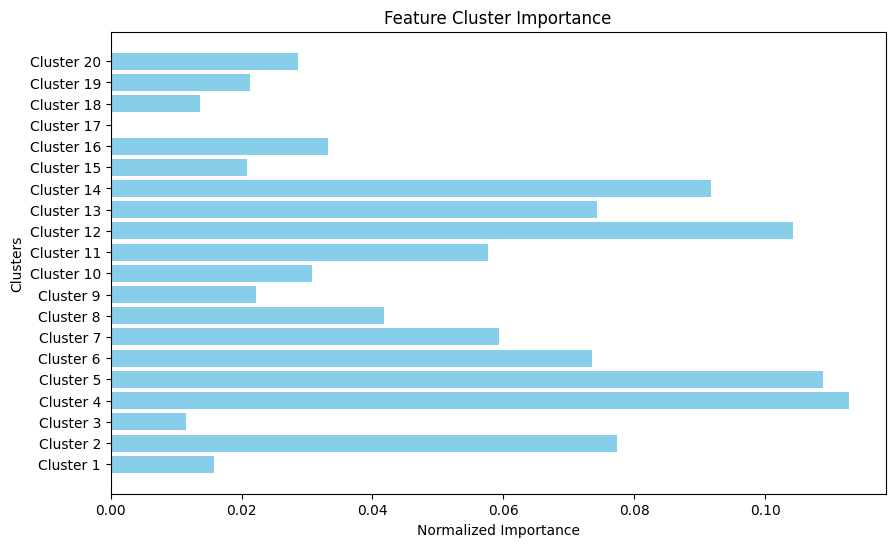

Cluster details:

Cluster 1 features:
  d1_arterial_ph_avg (SHAP: 0.0652)

Cluster 2 features:
  dcs_group (SHAP: 0.3181)

Cluster 3 features:
  d1_diasbp_diff (SHAP: 0.0073)
  d1_albumin_diff (SHAP: 0.0051)
  d1_bilirubin_diff (SHAP: 0.0053)
  d1_bun_diff (SHAP: 0.0055)
  d1_creatinine_diff (SHAP: 0.0071)
  d1_hemaglobin_diff (SHAP: 0.0050)
  d1_hematocrit_diff (SHAP: 0.0071)
  d1_potassium_diff (SHAP: 0.0051)

Cluster 4 features:
  d1_heartrate_avg (SHAP: 0.1163)
  d1_resprate_avg (SHAP: 0.1163)
  dx_class (SHAP: 0.1117)
  elective_surgery (SHAP: 0.1197)

Cluster 5 features:
  d1_lactate_avg (SHAP: 0.4478)

Cluster 6 features:
  d1_mbp_avg (SHAP: 0.0413)
  d1_glucose_avg (SHAP: 0.0372)
  d1_platelets_avg (SHAP: 0.0392)
  d1_sodium_avg (SHAP: 0.0393)
  d1_sysbp_diff (SHAP: 0.0351)
  d1_arterial_ph_diff (SHAP: 0.0375)
  icu_admit_source (SHAP: 0.0340)
  diabetes_mellitus (SHAP: 0.0392)

Cluster 7 features:
  d1_bun_avg (SHAP: 0.2438)

Cluster 8 features:
  age (SHAP: 0.1717)

Cluster 9

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:49:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.19326	validation_0-auc:0.90719	validation_0-aucpr:0.54005	validation_1-logloss:0.19570	validation_1-auc:0.90319	validation_1-aucpr:0.48982
[20]	validation_0-logloss:0.16449	validation_0-auc:0.91697	validation_0-aucpr:0.56302	validation_1-logloss:0.16842	validation_1-auc:0.91035	validation_1-aucpr:0.50462
[30]	validation_0-logloss:0.14751	validation_0-auc:0.92221	validation_0-aucpr:0.57984	validation_1-logloss:0.15300	validation_1-auc:0.91403	validation_1-aucpr:0.51164
[40]	validation_0-logloss:0.13642	validation_0-auc:0.92742	validation_0-aucpr:0.59656	validation_1-logloss:0.14351	validation_1-auc:0.91595	validation_1-aucpr:0.52152
[50]	validation_0-logloss:0.12881	validation_0-auc:0.93242	validation_0-aucpr:0.61193	validation_1-logloss:0.13777	validation_1-auc:0.91788	validation_1-aucpr:0.52725
[60]	validation_0-logloss:0.12342	validation_0-auc:0.93655	validation_0-aucpr:0.62551	validation_1-logloss:0.13420	validation_1-auc:0.91944	validation_1-aucpr:0.5312

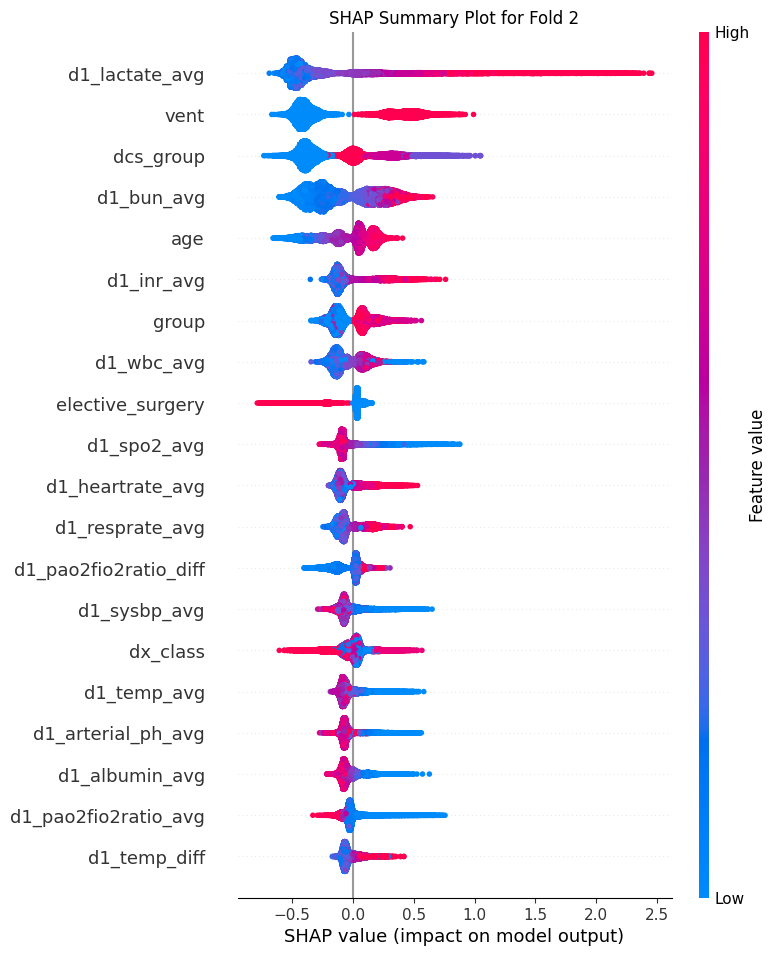

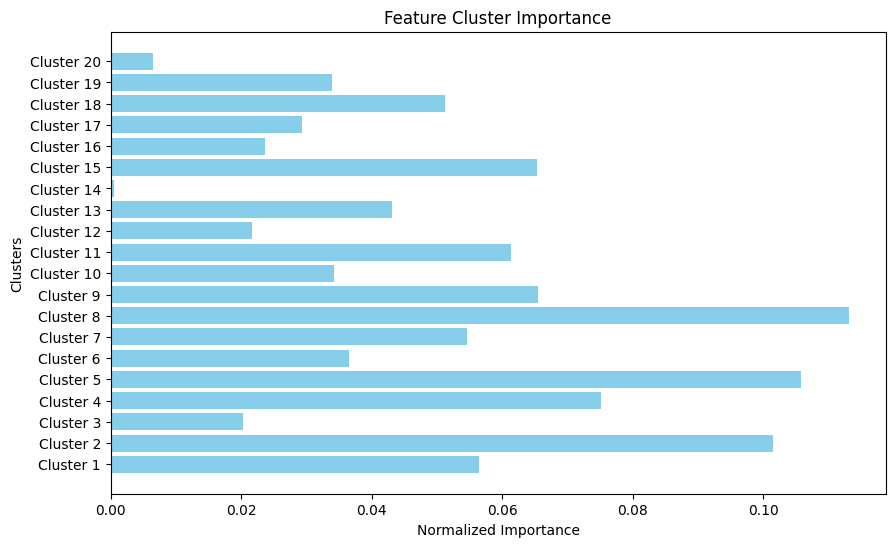

Cluster details:

Cluster 1 features:
  d1_temp_avg (SHAP: 0.0773)
  d1_albumin_avg (SHAP: 0.0711)
  d1_arterial_ph_avg (SHAP: 0.0773)

Cluster 2 features:
  vent (SHAP: 0.4062)

Cluster 3 features:
  d1_mbp_diff (SHAP: 0.0113)
  d1_albumin_diff (SHAP: 0.0078)
  d1_bun_diff (SHAP: 0.0075)
  d1_hematocrit_diff (SHAP: 0.0090)
  d1_inr_diff (SHAP: 0.0075)
  d1_platelets_diff (SHAP: 0.0104)
  d1_potassium_diff (SHAP: 0.0082)
  d1_calcium_diff (SHAP: 0.0076)
  solid_tumor_with_metastasis (SHAP: 0.0116)

Cluster 4 features:
  dcs_group (SHAP: 0.3009)

Cluster 5 features:
  d1_heartrate_avg (SHAP: 0.1048)
  d1_resprate_avg (SHAP: 0.1032)
  d1_spo2_avg (SHAP: 0.1076)
  elective_surgery (SHAP: 0.1076)

Cluster 6 features:
  d1_inr_avg (SHAP: 0.1459)

Cluster 7 features:
  d1_mbp_avg (SHAP: 0.0351)
  d1_bilirubin_avg (SHAP: 0.0361)
  d1_sodium_avg (SHAP: 0.0336)
  d1_sysbp_diff (SHAP: 0.0407)
  d1_arterial_ph_diff (SHAP: 0.0337)
  diabetes_mellitus (SHAP: 0.0389)

Cluster 8 features:
  d1_lactat

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.19259	validation_0-auc:0.90971	validation_0-aucpr:0.53701	validation_1-logloss:0.19504	validation_1-auc:0.90171	validation_1-aucpr:0.48463
[20]	validation_0-logloss:0.16402	validation_0-auc:0.91616	validation_0-aucpr:0.56086	validation_1-logloss:0.16853	validation_1-auc:0.90416	validation_1-aucpr:0.49735
[30]	validation_0-logloss:0.14701	validation_0-auc:0.92299	validation_0-aucpr:0.57841	validation_1-logloss:0.15350	validation_1-auc:0.90868	validation_1-aucpr:0.50848
[40]	validation_0-logloss:0.13606	validation_0-auc:0.92820	validation_0-aucpr:0.59587	validation_1-logloss:0.14449	validation_1-auc:0.91145	validation_1-aucpr:0.51674
[50]	validation_0-logloss:0.12862	validation_0-auc:0.93286	validation_0-aucpr:0.60971	validation_1-logloss:0.13880	validation_1-auc:0.91445	validation_1-aucpr:0.52215
[60]	validation_0-logloss:0.12317	validation_0-auc:0.93721	validation_0-aucpr:0.62483	validation_1-logloss:0.13534	validation_1-auc:0.91673	validation_1-aucpr:0.5274

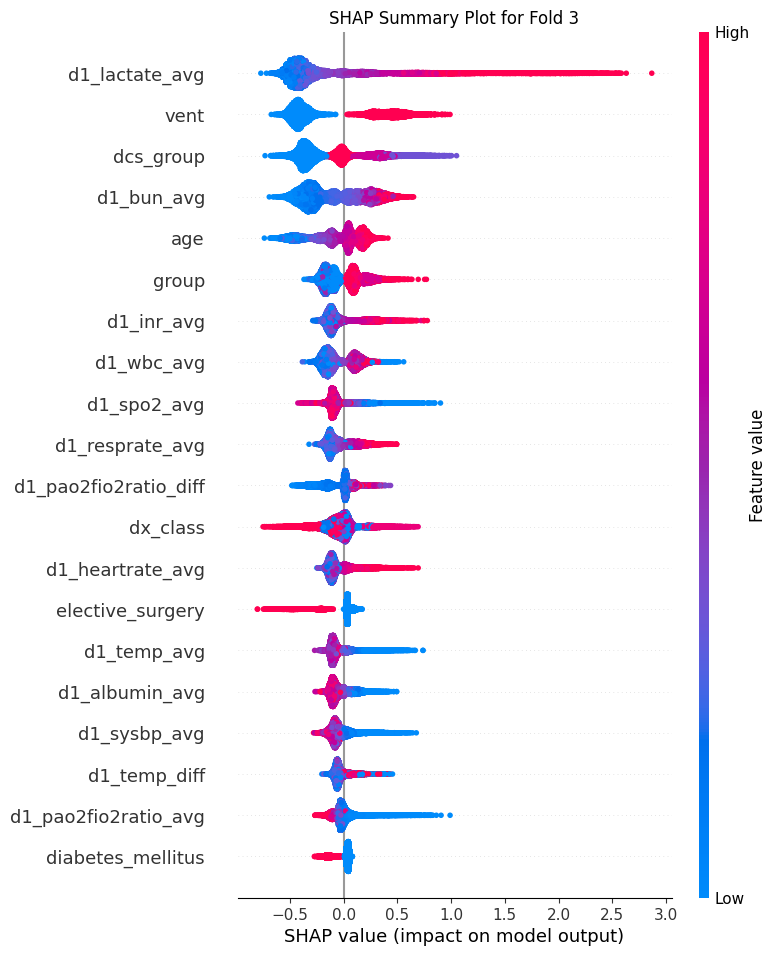

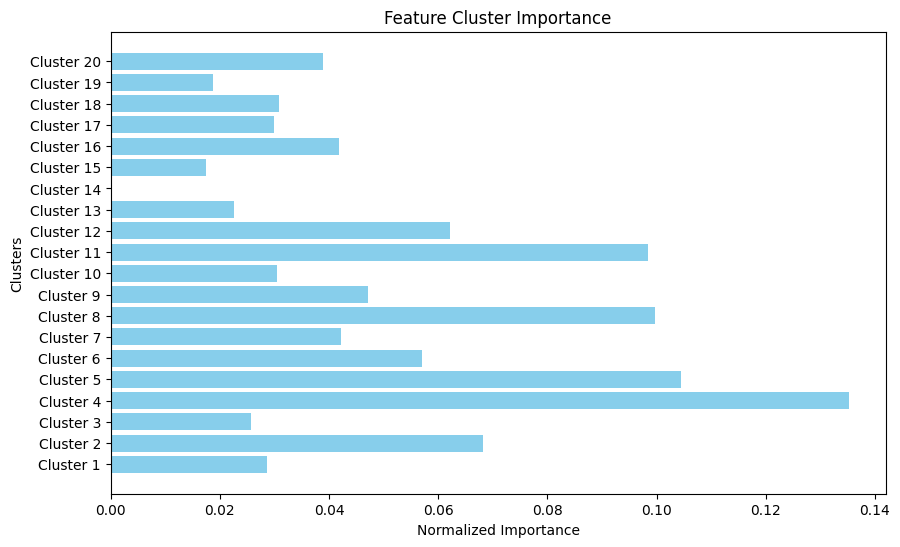

Cluster details:

Cluster 1 features:
  d1_arterial_ph_avg (SHAP: 0.0588)
  diabetes_mellitus (SHAP: 0.0618)

Cluster 2 features:
  dcs_group (SHAP: 0.2874)

Cluster 3 features:
  d1_albumin_diff (SHAP: 0.0092)
  d1_bilirubin_diff (SHAP: 0.0074)
  d1_creatinine_diff (SHAP: 0.0095)
  d1_glucose_diff (SHAP: 0.0107)
  d1_hco3_diff (SHAP: 0.0084)
  d1_hemaglobin_diff (SHAP: 0.0102)
  d1_hematocrit_diff (SHAP: 0.0073)
  d1_inr_diff (SHAP: 0.0093)
  d1_platelets_diff (SHAP: 0.0103)
  d1_potassium_diff (SHAP: 0.0082)
  d1_calcium_diff (SHAP: 0.0090)
  solid_tumor_with_metastasis (SHAP: 0.0093)

Cluster 4 features:
  d1_heartrate_avg (SHAP: 0.1101)
  d1_resprate_avg (SHAP: 0.1155)
  d1_spo2_avg (SHAP: 0.1172)
  d1_pao2fio2ratio_diff (SHAP: 0.1142)
  dx_class (SHAP: 0.1134)

Cluster 5 features:
  d1_lactate_avg (SHAP: 0.4406)

Cluster 6 features:
  d1_glucose_avg (SHAP: 0.0335)
  d1_sodium_avg (SHAP: 0.0371)
  d1_sysbp_diff (SHAP: 0.0320)
  d1_lactate_diff (SHAP: 0.0335)
  d1_sodium_diff (SHAP:

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:54:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.19281	validation_0-auc:0.90747	validation_0-aucpr:0.54210	validation_1-logloss:0.19649	validation_1-auc:0.89211	validation_1-aucpr:0.48187
[20]	validation_0-logloss:0.16376	validation_0-auc:0.91817	validation_0-aucpr:0.56739	validation_1-logloss:0.17006	validation_1-auc:0.90037	validation_1-aucpr:0.49228
[30]	validation_0-logloss:0.14640	validation_0-auc:0.92369	validation_0-aucpr:0.58356	validation_1-logloss:0.15486	validation_1-auc:0.90438	validation_1-aucpr:0.49999
[40]	validation_0-logloss:0.13543	validation_0-auc:0.92848	validation_0-aucpr:0.60026	validation_1-logloss:0.14601	validation_1-auc:0.90718	validation_1-aucpr:0.50670
[50]	validation_0-logloss:0.12786	validation_0-auc:0.93327	validation_0-aucpr:0.61535	validation_1-logloss:0.14053	validation_1-auc:0.90998	validation_1-aucpr:0.51158
[60]	validation_0-logloss:0.12242	validation_0-auc:0.93751	validation_0-aucpr:0.62938	validation_1-logloss:0.13715	validation_1-auc:0.91255	validation_1-aucpr:0.5164

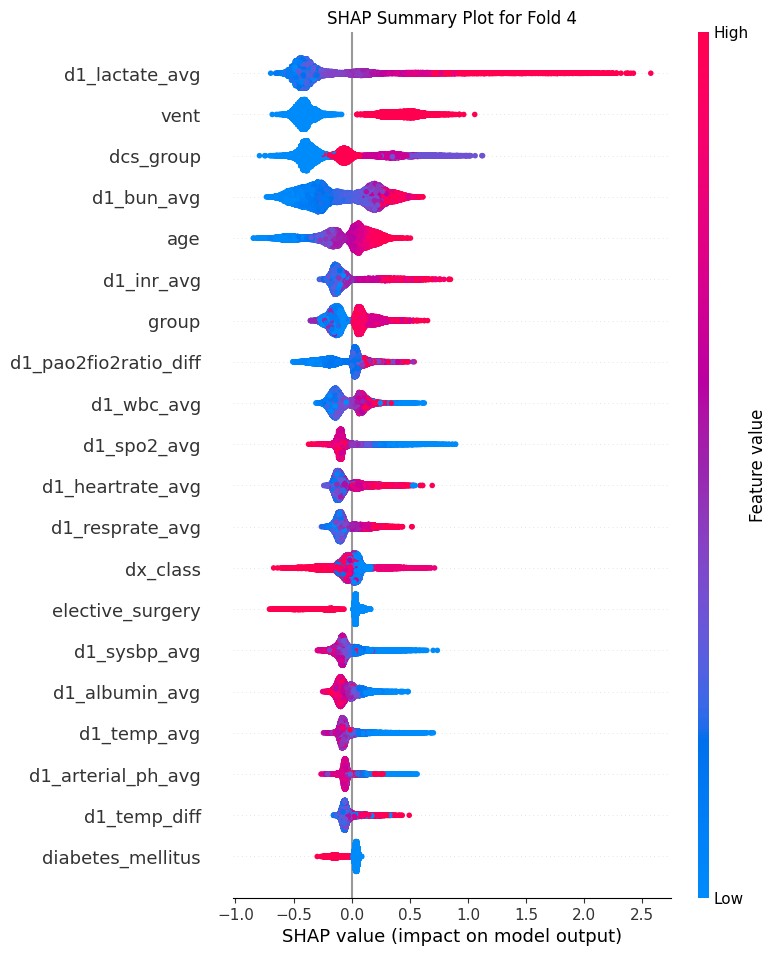

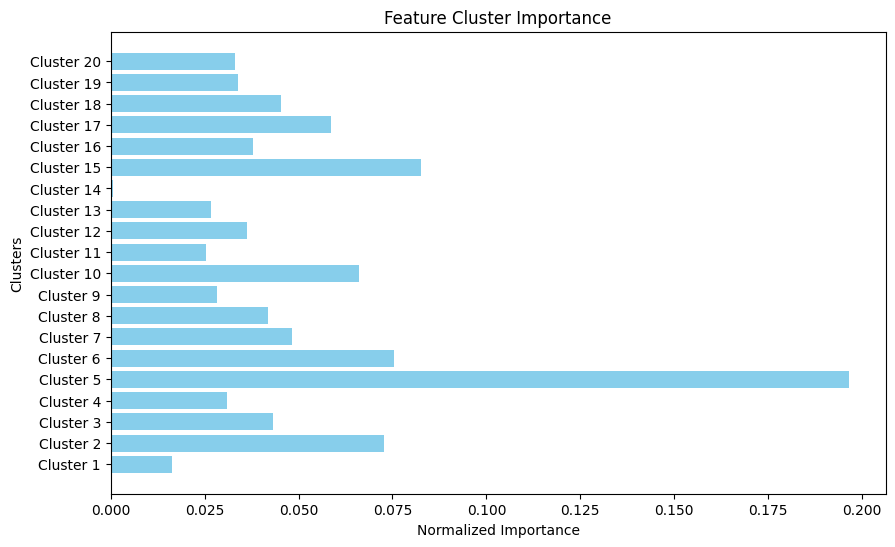

Cluster details:

Cluster 1 features:
  d1_arterial_ph_avg (SHAP: 0.0690)

Cluster 2 features:
  dcs_group (SHAP: 0.3089)

Cluster 3 features:
  d1_diasbp_avg (SHAP: 0.0175)
  d1_hco3_avg (SHAP: 0.0158)
  d1_hemaglobin_avg (SHAP: 0.0180)
  d1_hematocrit_avg (SHAP: 0.0138)
  d1_calcium_avg (SHAP: 0.0183)
  d1_arterial_pco2_avg (SHAP: 0.0185)
  d1_mbp_diff (SHAP: 0.0199)
  d1_lactate_diff (SHAP: 0.0156)
  d1_platelets_diff (SHAP: 0.0137)
  d1_potassium_diff (SHAP: 0.0152)
  solid_tumor_with_metastasis (SHAP: 0.0163)

Cluster 4 features:
  d1_pao2fio2ratio_diff (SHAP: 0.1313)

Cluster 5 features:
  d1_lactate_avg (SHAP: 0.4193)
  vent (SHAP: 0.4135)

Cluster 6 features:
  d1_mbp_avg (SHAP: 0.0443)
  d1_glucose_avg (SHAP: 0.0437)
  d1_platelets_avg (SHAP: 0.0454)
  d1_arterial_po2_avg (SHAP: 0.0471)
  d1_spo2_diff (SHAP: 0.0492)
  d1_sysbp_diff (SHAP: 0.0492)
  d1_arterial_ph_diff (SHAP: 0.0409)

Cluster 7 features:
  d1_resprate_avg (SHAP: 0.1051)
  dx_class (SHAP: 0.0999)

Cluster 8 feat

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:56:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.19303	validation_0-auc:0.91126	validation_0-aucpr:0.54561	validation_1-logloss:0.19559	validation_1-auc:0.89695	validation_1-aucpr:0.49016
[20]	validation_0-logloss:0.16398	validation_0-auc:0.91971	validation_0-aucpr:0.57100	validation_1-logloss:0.16896	validation_1-auc:0.90183	validation_1-aucpr:0.50118
[30]	validation_0-logloss:0.14673	validation_0-auc:0.92522	validation_0-aucpr:0.58544	validation_1-logloss:0.15375	validation_1-auc:0.90492	validation_1-aucpr:0.50998
[40]	validation_0-logloss:0.13564	validation_0-auc:0.92931	validation_0-aucpr:0.60018	validation_1-logloss:0.14469	validation_1-auc:0.90738	validation_1-aucpr:0.51614
[50]	validation_0-logloss:0.12805	validation_0-auc:0.93369	validation_0-aucpr:0.61473	validation_1-logloss:0.13921	validation_1-auc:0.90927	validation_1-aucpr:0.52305
[60]	validation_0-logloss:0.12275	validation_0-auc:0.93787	validation_0-aucpr:0.62767	validation_1-logloss:0.13578	validation_1-auc:0.91168	validation_1-aucpr:0.5280

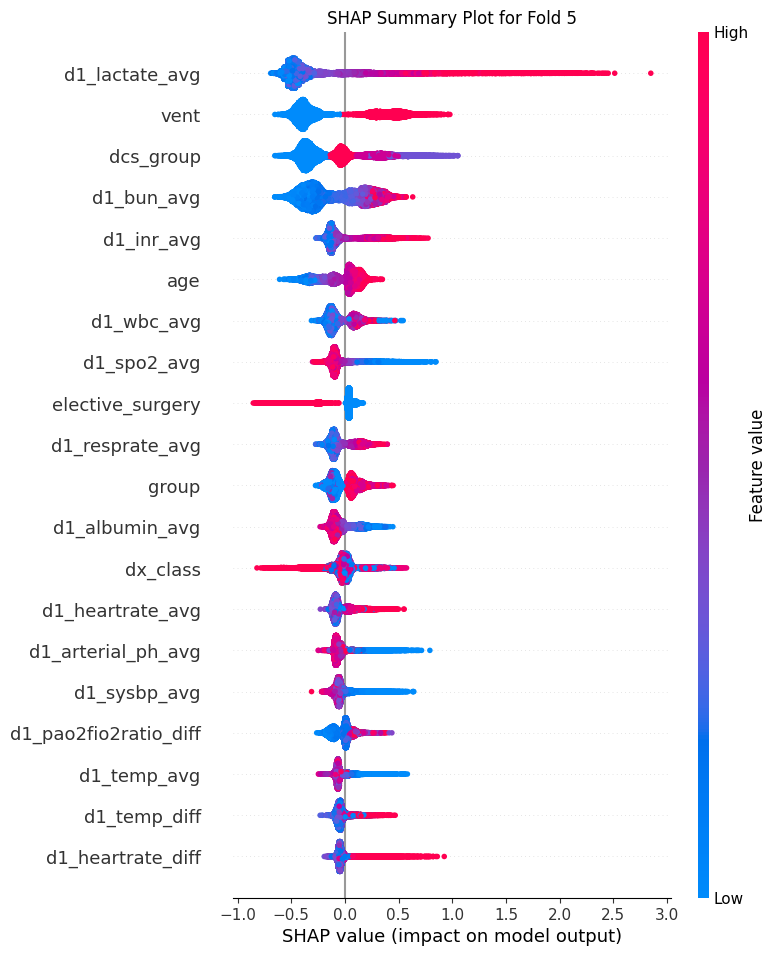

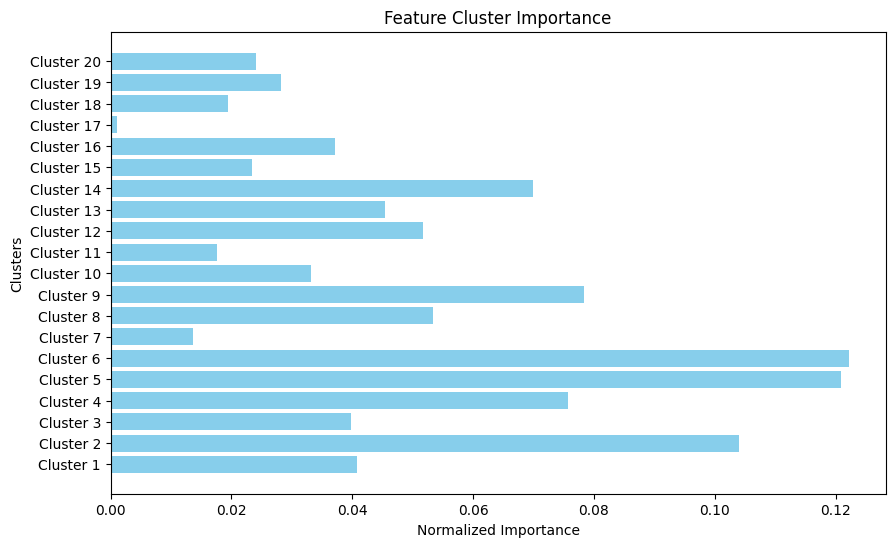

Cluster details:

Cluster 1 features:
  d1_sysbp_avg (SHAP: 0.0768)
  d1_arterial_ph_avg (SHAP: 0.0768)

Cluster 2 features:
  vent (SHAP: 0.3916)

Cluster 3 features:
  d1_glucose_avg (SHAP: 0.0202)
  d1_hco3_avg (SHAP: 0.0196)
  d1_hemaglobin_avg (SHAP: 0.0175)
  d1_potassium_avg (SHAP: 0.0162)
  d1_calcium_avg (SHAP: 0.0204)
  d1_mbp_diff (SHAP: 0.0160)
  d1_lactate_diff (SHAP: 0.0188)
  d1_arterial_ph_diff (SHAP: 0.0215)

Cluster 4 features:
  dcs_group (SHAP: 0.2850)

Cluster 5 features:
  d1_resprate_avg (SHAP: 0.1110)
  d1_spo2_avg (SHAP: 0.1144)
  d1_wbc_avg (SHAP: 0.1158)
  elective_surgery (SHAP: 0.1140)

Cluster 6 features:
  d1_lactate_avg (SHAP: 0.4600)

Cluster 7 features:
  d1_hematocrit_avg (SHAP: 0.0131)
  d1_arterial_pco2_avg (SHAP: 0.0098)
  d1_diasbp_diff (SHAP: 0.0092)
  d1_resprate_diff (SHAP: 0.0110)
  solid_tumor_with_metastasis (SHAP: 0.0083)

Cluster 8 features:
  d1_diasbp_avg (SHAP: 0.0340)
  d1_mbp_avg (SHAP: 0.0324)
  d1_bilirubin_avg (SHAP: 0.0324)
  d1_p

([np.float64(0.9212642368262567),
  np.float64(0.9291757475130957),
  np.float64(0.9257375172328124),
  np.float64(0.9222967637249715),
  np.float64(0.9208192060317892)],
 [np.float64(0.5421829670492545),
  np.float64(0.5586430140431871),
  np.float64(0.553794439333519),
  np.float64(0.5412851454452932),
  np.float64(0.5492965580666369)])

In [ ]:
def run_cv_with_model(X, y, model_name='xgboost', feature_names=None, num_clusters=20):
    """with 5 fold cross validation"""
    print("\n" + "="*60)
    print(f"【{model_name.upper()}】starting five fold cross validation - {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*60)
    print("📊 original data distribution:")
    print(f"  negative: {np.sum(y == 0)} | positive: {np.sum(y == 1)}")
    print(f"  positive percentage: {np.mean(y):.2%}\n")

    # data check
    assert len(X) == len(y), "❌ size between features and labels！"
    assert not np.isnan(y).any(), "❌ include missing data！"
    assert len(np.unique(y)) > 1, "❌ only one type of label！"

    # Initialize 5 fold cross validation
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # For each fold
    print("\n🔍 per fold result：")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        y_train, y_val = y[train_idx], y[val_idx]
        diff = abs(y_train.mean() - y_val.mean()) * 100
        status = "✅" if diff < 1 else "❌"
        print(f"  {status} Fold {fold + 1}: training {y_train.mean():.2%} positive | "
              f"validation {y_val.mean():.2%} positive | difference: {diff:.2f}%")

    # Initialize output lists
    auroc_scores = []
    auprc_scores = []
    training_times = []
    fold_models = []

    # For training
    print(f"\n🏋️ training begin {model_name.upper()} model...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold_start_time = time.time()
        print("\n" + "="*60)
        print(f"🔄 FOLD {fold + 1}/{n_splits} - {time.strftime('%H:%M:%S')}")
        print(f"  training: {len(train_idx)} | validation: {len(val_idx)}")
        print(f"  positive percentage in training: {y[train_idx].mean():.2%} | positive percentage in validation: {y[val_idx].mean():.2%}")
        print("="*60)

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if model_name == 'xgboost':
            model = XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42 + fold,
                use_label_encoder=False,
                eval_metric=['logloss', 'auc', 'aucpr'],
                early_stopping_rounds=10,
                verbosity=1
            )
            print("\n⚙️ XGBoost parameter:")
            print(f"  n_estimators=200 | max_depth=6 | lr=0.05")
            print(f"  early_stopping=20 | eval_metric=[logloss, auc, aucpr]")

        elif model_name == 'randomforest':
            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=42 + fold,
                class_weight='balanced',
                verbose=0,
                n_jobs=-1
            )
            print("\n⚙️ Random Forest parameter:")
            print(f"  n_estimators=200 | max_depth=None")
            print(f"  class_weight=balanced | n_jobs=-1")

        # Training process
        print("\n⏳ training process:")
        if model_name == 'xgboost':
            # For XGBoost
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                verbose=10  # output per 10 epochs
            )

            # Print the output
            results = model.evals_result()
            for metric in ['logloss', 'auc', 'aucpr']:
                print(f"  {metric.upper():<8} final value: "
                      f"training={results['validation_0'][metric][-1]:.4f} | "
                      f"validation={results['validation_1'][metric][-1]:.4f}")
        else:
            # Random Forest training
            print("  RF training begins")
            with tqdm(total=model.n_estimators, desc="tree building") as pbar:
                model.fit(X_train, y_train)
                pbar.update(model.n_estimators)

            # Output the tree built process
            print("\n🌲 tree built completed:")
            print(f"  number of trees built: {len(model.estimators_)}")
            print(f"  average depth of each tree: "
                  f"{np.mean([tree.tree_.max_depth for tree in model.estimators_]):.1f}")

        # Evaluate the model
        fold_time = time.time() - fold_start_time
        training_times.append(fold_time)

        preds = model.predict_proba(X_val)
        if preds.shape[1] == 2:  # binary classification
            preds = preds[:, 1]
            auroc = roc_auc_score(y_val, preds)
            auprc = average_precision_score(y_val, preds)
        else:  # multiple classification
            auroc = roc_auc_score(y_val, preds, multi_class='ovr')
            auprc = average_precision_score(y_val, preds, average='macro')

        print(f"\n🎯 Fold {fold + 1} result:")
        print(f"  ⏱️ time: {fold_time:.1f} seconds")
        print(f"  🎯 AUROC: {auroc:.4f}")
        print(f"  🎯 AUPRC: {auprc:.4f}")

        auroc_scores.append(auroc)
        auprc_scores.append(auprc)
        fold_models.append(model)

        # Model save
        save_folder = f'saved_models_{model_name}'
        os.makedirs(save_folder, exist_ok=True)

        if model_name == 'xgboost':
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.json')
            model.save_model(model_save_path)
        else:
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.pkl')
            joblib.dump(model, model_save_path)

        print(f"💾 model saved to: {model_save_path}")

        # SHAP plotting and cluster importance calculation
        if model_name in ['xgboost', 'randomforest']:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_val)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # For binary classification

            # Plot SHAP summary
            plt.figure()
            shap.summary_plot(shap_values, X_val, feature_names=feature_names, show=False)
            plt.title(f'SHAP Summary Plot for Fold {fold+1}')
            plt.savefig(os.path.join(save_folder, f'shap_fold_{fold+1}.png'), dpi=300, bbox_inches='tight')
            plt.show()

            calculate_cluster_importance(feature_names, shap_values, num_clusters=num_clusters)

    # Final report
    print("\n\n" + "="*60)
    print(f"🔥 {model_name.upper()} final result - average training time: {np.mean(training_times):.1f} seconds per fold")
    print("="*60)
    print(f"📊 Avg AUROC: {np.mean(auroc_scores):.4f} ± {np.std(auroc_scores):.4f}")
    print(f"📊 Avg AUPRC: {np.mean(auprc_scores):.4f} ± {np.std(auprc_scores):.4f}")

    print("\n📝 results for each fold:")
    for fold in range(n_splits):
        print(f"  Fold {fold + 1}: "
              f"AUROC={auroc_scores[fold]:.4f} | "
              f"AUPRC={auprc_scores[fold]:.4f} | "
              f"time consumed={training_times[fold]:.1f} s")

    print(f"\n💾 all models are saved to : {save_folder}/")
    return auroc_scores, auprc_scores

# Train the model
feature_names = df_encoded[features].columns.tolist()
run_cv_with_model(X, y, 'xgboost', feature_names = feature_names, num_clusters = 20)

# RF train and interpretation

In [ ]:
!zip -r /content/RF_all_eICU.zip /content/saved_models_randomforest /content/saved_models_randomforest-real

In [ ]:
def calculate_cluster_importance(feature_names, importances, num_clusters=20):
    """
    Calculate and visualize the importance of feature clusters based on feature importances.

    """
    # Compute mean absolute feature importances
    mean_importances = np.abs(importances).reshape(-1, 1)

    # Clustering features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(mean_importances)
    feature_clusters = kmeans.labels_

    # Calculate cluster importance by summing feature importances within each cluster
    cluster_importance = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        cluster_importance[cluster] = mean_importances[cluster_indices].sum()

    # Normalize cluster importance
    total_importance = sum(cluster_importance.values())
    for cluster in cluster_importance:
        cluster_importance[cluster] /= total_importance

    # Visualization
    cluster_names = [f'Cluster {i+1}' for i in range(num_clusters)]
    cluster_values = [cluster_importance[i] for i in range(num_clusters)]

    plt.figure(figsize=(10, 6))
    plt.barh(cluster_names, cluster_values, color='skyblue')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Clusters')
    plt.title('Feature Cluster Importance')
    plt.show()

    # Print cluster details
    print("Cluster details:")
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        print(f"\nCluster {cluster + 1} features:")
        for idx in cluster_indices:
            print(f"  {feature_names[idx]} (Importance: {mean_importances[idx][0]:.4f})")

    return cluster_importance


【RANDOMFOREST】starting five fold cross validation - 2025-05-21 02:58:38
📊 original data distribution:
  negative: 123510 | positive: 7300
  positive percentage: 5.58%


🔍 per fold result：
  ✅ Fold 1: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 2: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 3: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 4: training 5.58% positive | validation 5.58% positive | difference: 0.00%
  ✅ Fold 5: training 5.58% positive | validation 5.58% positive | difference: 0.00%

🏋️ training begin RANDOMFOREST model...

🔄 FOLD 1/5 - 02:58:38
  training: 104648 | validation: 26162
  positive percentage in training: 5.58% | positive percentage in validation: 5.58%

⚙️ Random Forest parameter:
  n_estimators=200 | max_depth=None
  class_weight=balanced | n_jobs=-1

⏳ training process:
  RF training begins


tree building: 100%|██████████| 200/200 [02:12<00:00,  1.50it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 49.0

🎯 Fold 1 result:
  ⏱️ time: 133.0 seconds
  🎯 AUROC: 0.9118
  🎯 AUPRC: 0.4949

🔥 Top 20 Important Features for Fold 1:

                       Importance
d1_lactate_avg           0.089552
vent                     0.063885
dcs_group                0.042968
d1_arterial_ph_avg       0.040115
d1_inr_avg               0.038069
d1_bun_avg               0.034391
d1_spo2_avg              0.028527
d1_pao2fio2ratio_diff    0.028455
d1_creatinine_avg        0.023570
d1_spo2_diff             0.023268
d1_hco3_avg              0.022573
dx_class                 0.020275
dx_sub                   0.019598
d1_pao2fio2ratio_avg     0.018703
d1_lactate_diff          0.018418
d1_sysbp_avg             0.018167
d1_arterial_po2_avg      0.018066
d1_temp_avg              0.018044
d1_albumin_avg           0.017992
d1_arterial_ph_diff      0.017576


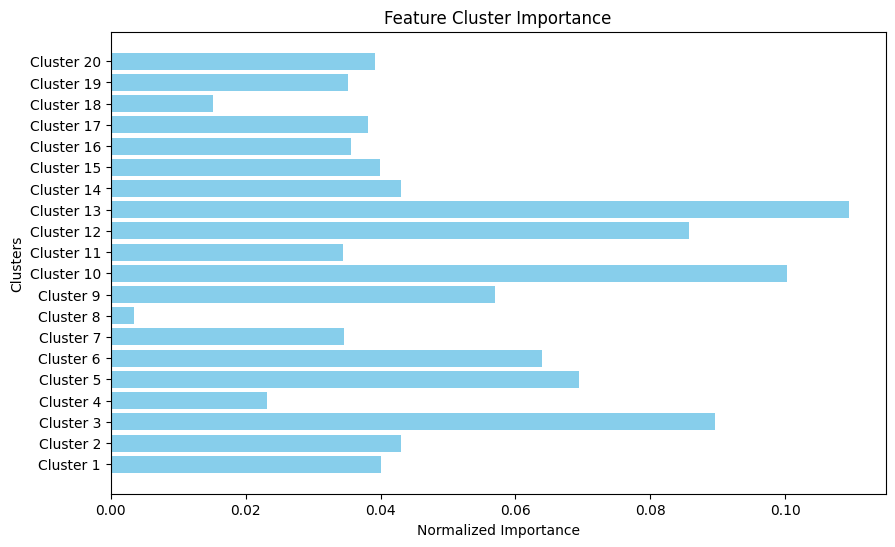

Cluster details:

Cluster 1 features:
  d1_arterial_ph_avg (Importance: 0.0401)

Cluster 2 features:
  d1_hemaglobin_avg (Importance: 0.0103)
  d1_hematocrit_avg (Importance: 0.0106)
  d1_potassium_avg (Importance: 0.0110)
  d1_sysbp_diff (Importance: 0.0111)

Cluster 3 features:
  d1_lactate_avg (Importance: 0.0896)

Cluster 4 features:
  d1_creatinine_diff (Importance: 0.0065)
  d1_platelets_diff (Importance: 0.0055)
  d1_potassium_diff (Importance: 0.0054)
  icu_admit_source (Importance: 0.0057)

Cluster 5 features:
  d1_creatinine_avg (Importance: 0.0236)
  d1_hco3_avg (Importance: 0.0226)
  d1_spo2_diff (Importance: 0.0233)

Cluster 6 features:
  vent (Importance: 0.0639)

Cluster 7 features:
  d1_wbc_avg (Importance: 0.0170)
  d1_arterial_ph_diff (Importance: 0.0176)

Cluster 8 features:
  arf_apache (Importance: 0.0005)
  aids (Importance: 0.0002)
  cirrhosis (Importance: 0.0005)
  diabetes_mellitus (Importance: 0.0013)
  lymphoma (Importance: 0.0002)
  solid_tumor_with_metastas

tree building: 100%|██████████| 200/200 [02:06<00:00,  1.58it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 48.5

🎯 Fold 2 result:
  ⏱️ time: 126.9 seconds
  🎯 AUROC: 0.9148
  🎯 AUPRC: 0.4883

🔥 Top 20 Important Features for Fold 2:

                       Importance
d1_lactate_avg           0.107459
vent                     0.055023
d1_arterial_ph_avg       0.042725
d1_inr_avg               0.041715
dcs_group                0.039168
d1_bun_avg               0.033128
d1_pao2fio2ratio_diff    0.029304
d1_spo2_avg              0.026699
d1_creatinine_avg        0.024706
d1_spo2_diff             0.022429
dx_sub                   0.019111
dx_class                 0.018213
d1_pao2fio2ratio_avg     0.018155
d1_temp_avg              0.018007
d1_wbc_avg               0.017741
d1_lactate_diff          0.017187
d1_arterial_po2_avg      0.017010
d1_albumin_avg           0.016956
d1_sysbp_avg             0.016842
d1_arterial_ph_diff      0.016776


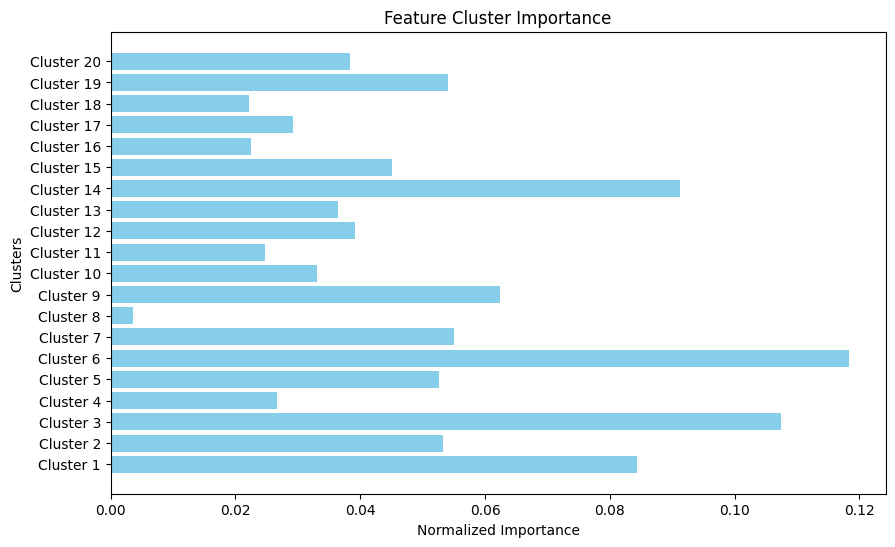

Cluster details:

Cluster 1 features:
  d1_inr_avg (Importance: 0.0417)
  d1_arterial_ph_avg (Importance: 0.0427)

Cluster 2 features:
  d1_diasbp_avg (Importance: 0.0109)
  d1_hemaglobin_avg (Importance: 0.0105)
  d1_hematocrit_avg (Importance: 0.0105)
  d1_potassium_avg (Importance: 0.0110)
  d1_sodium_avg (Importance: 0.0103)

Cluster 3 features:
  d1_lactate_avg (Importance: 0.1075)

Cluster 4 features:
  d1_spo2_avg (Importance: 0.0267)

Cluster 5 features:
  d1_bun_diff (Importance: 0.0053)
  d1_hco3_diff (Importance: 0.0049)
  d1_hemaglobin_diff (Importance: 0.0051)
  d1_hematocrit_diff (Importance: 0.0052)
  d1_platelets_diff (Importance: 0.0053)
  d1_potassium_diff (Importance: 0.0055)
  d1_sodium_diff (Importance: 0.0051)
  d1_calcium_diff (Importance: 0.0053)
  d1_wbc_diff (Importance: 0.0052)
  icu_admit_source (Importance: 0.0057)

Cluster 6 features:
  d1_sysbp_avg (Importance: 0.0168)
  d1_albumin_avg (Importance: 0.0170)
  d1_hco3_avg (Importance: 0.0168)
  d1_arterial_

tree building: 100%|██████████| 200/200 [02:11<00:00,  1.53it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 49.0

🎯 Fold 3 result:
  ⏱️ time: 131.2 seconds
  🎯 AUROC: 0.9144
  🎯 AUPRC: 0.4827

🔥 Top 20 Important Features for Fold 3:

                       Importance
d1_lactate_avg           0.099778
vent                     0.055512
d1_arterial_ph_avg       0.042868
dcs_group                0.042389
d1_inr_avg               0.042223
d1_bun_avg               0.035310
d1_spo2_avg              0.030339
d1_pao2fio2ratio_diff    0.027492
d1_temp_avg              0.022345
d1_spo2_diff             0.020959
dx_class                 0.020408
d1_creatinine_avg        0.019932
dx_sub                   0.019819
d1_arterial_ph_diff      0.019421
d1_lactate_diff          0.019386
d1_sysbp_avg             0.017872
d1_pao2fio2ratio_avg     0.017570
d1_wbc_avg               0.017480
d1_albumin_avg           0.017170
d1_arterial_po2_avg      0.016292


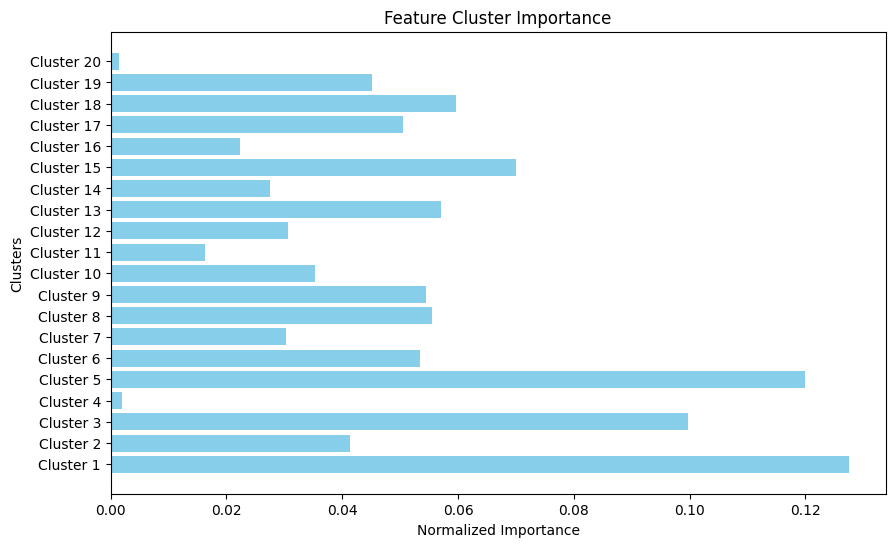

Cluster details:

Cluster 1 features:
  d1_inr_avg (Importance: 0.0422)
  d1_arterial_ph_avg (Importance: 0.0429)
  dcs_group (Importance: 0.0424)

Cluster 2 features:
  d1_hemaglobin_avg (Importance: 0.0105)
  d1_hematocrit_avg (Importance: 0.0105)
  d1_sodium_avg (Importance: 0.0100)
  group (Importance: 0.0102)

Cluster 3 features:
  d1_lactate_avg (Importance: 0.0998)

Cluster 4 features:
  arf_apache (Importance: 0.0005)
  aids (Importance: 0.0002)
  cirrhosis (Importance: 0.0004)
  lymphoma (Importance: 0.0003)
  solid_tumor_with_metastasis (Importance: 0.0006)

Cluster 5 features:
  d1_creatinine_avg (Importance: 0.0199)
  d1_spo2_diff (Importance: 0.0210)
  d1_lactate_diff (Importance: 0.0194)
  d1_arterial_ph_diff (Importance: 0.0194)
  dx_class (Importance: 0.0204)
  dx_sub (Importance: 0.0198)

Cluster 6 features:
  d1_bun_diff (Importance: 0.0051)
  d1_hco3_diff (Importance: 0.0055)
  d1_hemaglobin_diff (Importance: 0.0050)
  d1_hematocrit_diff (Importance: 0.0051)
  d1_pla

tree building: 100%|██████████| 200/200 [02:08<00:00,  1.56it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 48.5

🎯 Fold 4 result:
  ⏱️ time: 128.3 seconds
  🎯 AUROC: 0.9105
  🎯 AUPRC: 0.4738

🔥 Top 20 Important Features for Fold 4:

                       Importance
d1_lactate_avg           0.095885
vent                     0.061639
dcs_group                0.043968
d1_inr_avg               0.042310
d1_arterial_ph_avg       0.039950
d1_bun_avg               0.032251
d1_spo2_avg              0.028936
d1_pao2fio2ratio_diff    0.028635
d1_spo2_diff             0.025697
d1_creatinine_avg        0.022614
d1_arterial_ph_diff      0.020529
dx_class                 0.020184
dx_sub                   0.019545
d1_temp_avg              0.018190
d1_hco3_avg              0.017584
d1_lactate_diff          0.017398
d1_pao2fio2ratio_avg     0.017287
d1_wbc_avg               0.016728
d1_sysbp_avg             0.016511
d1_heartrate_diff        0.015802


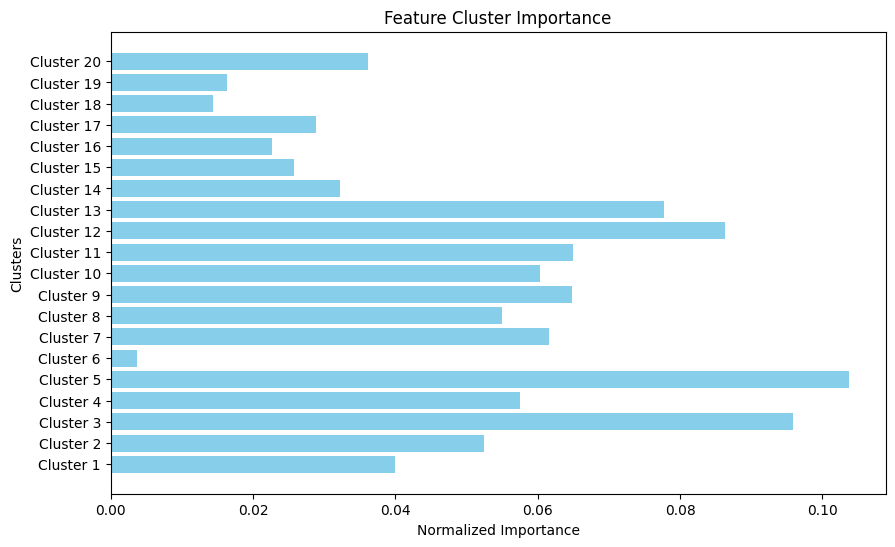

Cluster details:

Cluster 1 features:
  d1_arterial_ph_avg (Importance: 0.0400)

Cluster 2 features:
  d1_diasbp_avg (Importance: 0.0109)
  d1_hemaglobin_avg (Importance: 0.0101)
  d1_hematocrit_avg (Importance: 0.0104)
  d1_potassium_avg (Importance: 0.0108)
  d1_sodium_avg (Importance: 0.0102)

Cluster 3 features:
  d1_lactate_avg (Importance: 0.0959)

Cluster 4 features:
  d1_spo2_avg (Importance: 0.0289)
  d1_pao2fio2ratio_diff (Importance: 0.0286)

Cluster 5 features:
  d1_sysbp_avg (Importance: 0.0165)
  d1_temp_avg (Importance: 0.0182)
  d1_hco3_avg (Importance: 0.0176)
  d1_wbc_avg (Importance: 0.0167)
  d1_pao2fio2ratio_avg (Importance: 0.0173)
  d1_lactate_diff (Importance: 0.0174)

Cluster 6 features:
  arf_apache (Importance: 0.0006)
  aids (Importance: 0.0002)
  cirrhosis (Importance: 0.0004)
  diabetes_mellitus (Importance: 0.0015)
  lymphoma (Importance: 0.0003)
  solid_tumor_with_metastasis (Importance: 0.0008)

Cluster 7 features:
  vent (Importance: 0.0616)

Cluster 8

tree building: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 49.0

🎯 Fold 5 result:
  ⏱️ time: 131.0 seconds
  🎯 AUROC: 0.9092
  🎯 AUPRC: 0.4809

🔥 Top 20 Important Features for Fold 5:

                       Importance
d1_lactate_avg           0.100607
vent                     0.070403
d1_inr_avg               0.043773
dcs_group                0.040999
d1_arterial_ph_avg       0.036659
d1_bun_avg               0.034099
d1_pao2fio2ratio_diff    0.028121
d1_spo2_avg              0.027322
d1_spo2_diff             0.025370
d1_creatinine_avg        0.021382
dx_class                 0.018501
d1_temp_avg              0.017923
d1_sysbp_avg             0.017856
d1_albumin_avg           0.017689
dx_sub                   0.017667
d1_pao2fio2ratio_avg     0.017583
d1_hco3_avg              0.017434
d1_arterial_ph_diff      0.017397
d1_wbc_avg               0.016802
d1_lactate_diff          0.016576


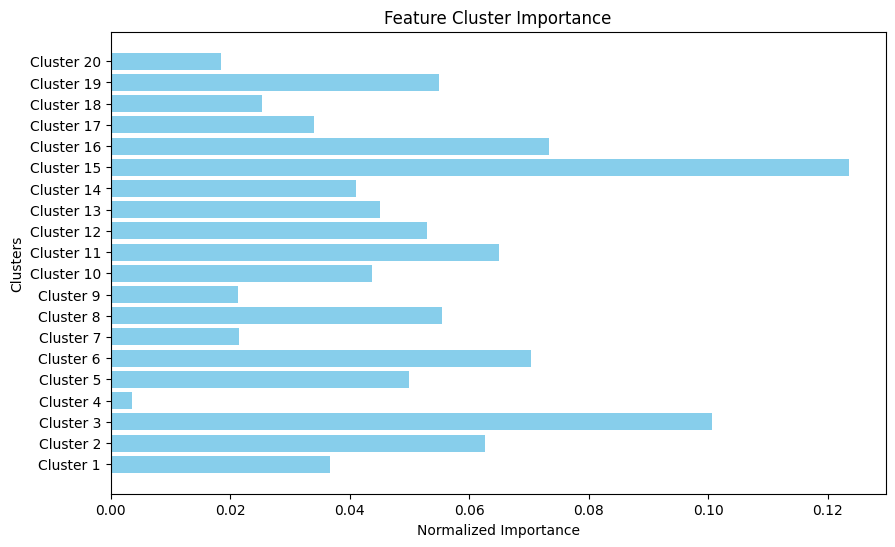

Cluster details:

Cluster 1 features:
  d1_arterial_ph_avg (Importance: 0.0367)

Cluster 2 features:
  d1_mbp_avg (Importance: 0.0124)
  d1_bilirubin_avg (Importance: 0.0131)
  d1_glucose_avg (Importance: 0.0128)
  d1_platelets_avg (Importance: 0.0118)
  d1_arterial_po2_diff (Importance: 0.0127)

Cluster 3 features:
  d1_lactate_avg (Importance: 0.1006)

Cluster 4 features:
  arf_apache (Importance: 0.0006)
  aids (Importance: 0.0002)
  cirrhosis (Importance: 0.0005)
  diabetes_mellitus (Importance: 0.0014)
  lymphoma (Importance: 0.0002)
  solid_tumor_with_metastasis (Importance: 0.0007)

Cluster 5 features:
  d1_wbc_avg (Importance: 0.0168)
  d1_arterial_po2_avg (Importance: 0.0165)
  d1_lactate_diff (Importance: 0.0166)

Cluster 6 features:
  vent (Importance: 0.0704)

Cluster 7 features:
  d1_albumin_diff (Importance: 0.0073)
  d1_bilirubin_diff (Importance: 0.0079)
  d1_creatinine_diff (Importance: 0.0064)

Cluster 8 features:
  d1_spo2_avg (Importance: 0.0273)
  d1_pao2fio2ratio_

([np.float64(0.9117578799564784),
  np.float64(0.9148320584102224),
  np.float64(0.9144136185523217),
  np.float64(0.910459901200391),
  np.float64(0.9091765904374666)],
 [np.float64(0.4949225499284945),
  np.float64(0.48827248708482396),
  np.float64(0.48269989561218074),
  np.float64(0.47383432490218735),
  np.float64(0.48090666007024696)])

In [ ]:
def run_cv_with_model(X, y, model_name='xgboost', feature_names=None, num_clusters=20):
    """Run 5-fold cross-validation with the specified model."""

    print("\n" + "="*60)
    print(f"【{model_name.upper()}】starting five fold cross validation - {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*60)
    print("📊 original data distribution:")
    print(f"  negative: {np.sum(y == 0)} | positive: {np.sum(y == 1)}")
    print(f"  positive percentage: {np.mean(y):.2%}\n")

    # Data check
    assert len(X) == len(y), "❌ size between features and labels！"
    assert not np.isnan(y).any(), "❌ include missing data！"
    assert len(np.unique(y)) > 1, "❌ only one type of label！"

    # Initialize 5-fold cross-validation
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # For each fold
    print("\n🔍 per fold result：")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        y_train, y_val = y[train_idx], y[val_idx]
        diff = abs(y_train.mean() - y_val.mean()) * 100
        status = "✅" if diff < 1 else "❌"
        print(f"  {status} Fold {fold + 1}: training {y_train.mean():.2%} positive | "
              f"validation {y_val.mean():.2%} positive | difference: {diff:.2f}%")

    # Initialize output lists
    auroc_scores = []
    auprc_scores = []
    training_times = []
    fold_models = []
    feature_importances_per_fold = []

    # For training
    print(f"\n🏋️ training begin {model_name.upper()} model...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold_start_time = time.time()
        print("\n" + "="*60)
        print(f"🔄 FOLD {fold + 1}/{n_splits} - {time.strftime('%H:%M:%S')}")
        print(f"  training: {len(train_idx)} | validation: {len(val_idx)}")
        print(f"  positive percentage in training: {y[train_idx].mean():.2%} | positive percentage in validation: {y[val_idx].mean():.2%}")
        print("="*60)

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if model_name == 'xgboost':
            model = XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42 + fold,
                use_label_encoder=False,
                eval_metric=['logloss', 'auc', 'aucpr'],
                early_stopping_rounds=10,
                verbosity=1
            )
            print("\n⚙️ XGBoost parameter:")
            print(f"  n_estimators=200 | max_depth=6 | lr=0.05")
            print(f"  early_stopping=20 | eval_metric=[logloss, auc, aucpr]")

        elif model_name == 'randomforest':
            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=42 + fold,
                class_weight='balanced',
                verbose=0,
                n_jobs=-1
            )
            print("\n⚙️ Random Forest parameter:")
            print(f"  n_estimators=200 | max_depth=None")
            print(f"  class_weight=balanced | n_jobs=-1")

        # Training process
        print("\n⏳ training process:")
        if model_name == 'xgboost':
            # For XGBoost
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                verbose=10  # output per 10 epochs
            )

            # Print the output
            results = model.evals_result()
            for metric in ['logloss', 'auc', 'aucpr']:
                print(f"  {metric.upper():<8} final value: "
                      f"training={results['validation_0'][metric][-1]:.4f} | "
                      f"validation={results['validation_1'][metric][-1]:.4f}")
        else:
            # Random Forest training
            print("  RF training begins")
            with tqdm(total=model.n_estimators, desc="tree building") as pbar:
                model.fit(X_train, y_train)
                pbar.update(model.n_estimators)

            # Output the tree built process
            print("\n🌲 tree built completed:")
            print(f"  number of trees built: {len(model.estimators_)}")
            print(f"  average depth of each tree: "
                  f"{np.mean([tree.tree_.max_depth for tree in model.estimators_]):.1f}")

        # Evaluate the model
        fold_time = time.time() - fold_start_time
        training_times.append(fold_time)

        preds = model.predict_proba(X_val)

        if preds.shape[1] == 2:  # binary classification
            preds = preds[:, 1]
            auroc = roc_auc_score(y_val, preds)
            auprc = average_precision_score(y_val, preds)
        else:  # multiple classification
            auroc = roc_auc_score(y_val, preds, multi_class='ovr')
            auprc = average_precision_score(y_val, preds, average='macro')

        print(f"\n🎯 Fold {fold + 1} result:")
        print(f"  ⏱️ time: {fold_time:.1f} seconds")
        print(f"  🎯 AUROC: {auroc:.4f}")
        print(f"  🎯 AUPRC: {auprc:.4f}")

        auroc_scores.append(auroc)
        auprc_scores.append(auprc)
        fold_models.append(model)

        # Model save
        save_folder = f'saved_models_{model_name}'
        os.makedirs(save_folder, exist_ok=True)

        if model_name == 'xgboost':
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.json')
            model.save_model(model_save_path)
        else:
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.pkl')
            joblib.dump(model, model_save_path)

        print(f"💾 model saved to: {model_save_path}")

        # Feature importance for Random Forest
        if model_name == 'randomforest':
            importances = model.feature_importances_
            importance_df = pd.DataFrame(importances, index=feature_names, columns=['Importance'])
            importance_df.sort_values(by='Importance', ascending=False, inplace=True)
            print(f"\n🔥 Top 20 Important Features for Fold {fold+1}:\n")
            print(importance_df.head(20))
            feature_importances_per_fold.append(importance_df.head(20))

            # Calculate cluster importance
            cluster_importance = calculate_cluster_importance(feature_names, importances, num_clusters=num_clusters)
            print(f"\n🔥 Cluster Importance for Fold {fold+1}:\n")
            print(cluster_importance)

    # Final report
    print("\n\n" + "="*60)
    print(f"🔥 {model_name.upper()} final result - average training time: {np.mean(training_times):.1f} seconds per fold")
    print("="*60)
    print(f"📊 Avg AUROC: {np.mean(auroc_scores):.4f} ± {np.std(auroc_scores):.4f}")
    print(f"📊 Avg AUPRC: {np.mean(auprc_scores):.4f} ± {np.std(auprc_scores):.4f}")

    print("\n📝 results for each fold:")
    for fold in range(n_splits):
        print(f"  Fold {fold + 1}: "
              f"AUROC={auroc_scores[fold]:.4f} | "
              f"AUPRC={auprc_scores[fold]:.4f} | "
              f"time consumed={training_times[fold]:.1f} s")

    print(f"\n💾 all models are saved to : {save_folder}/")
    return auroc_scores, auprc_scores


# Usage
feature_names = df_encoded[features].columns.tolist()
run_cv_with_model(X, y, model_name = 'randomforest', feature_names = feature_names, num_clusters = 20)

# load real data and data procession

In [ ]:
# Load the CSV file
file_path_2 = "/content/gossis-1-eicu-only.csv"  # Replace with your actual file path
df_2 = pd.read_csv(file_path_2)

In [ ]:
# Find column names in df_1 that end with '_avg'
avg_columns = [col for col in df_1.columns if col.endswith('_avg')]

# Initialize lists to store the corresponding _min and _max column names
min_columns = {}
max_columns = {}

# Loop through each _avg column to find corresponding _min and _max columns in df_2
for avg_col in avg_columns:
    base_col_name = avg_col[:-4]  # Remove the '_avg' suffix

    min_col = base_col_name + '_min'
    max_col = base_col_name + '_max'

    if min_col in df_2.columns and max_col in df_2.columns:
        min_columns[avg_col] = min_col
        max_columns[avg_col] = max_col
    else:
        print(f"Corresponding columns for {avg_col} not found in df_2")

# Print the result
print(f"Number of _avg columns found: {len(avg_columns)}")

for avg_col in avg_columns:
    if avg_col in min_columns and avg_col in max_columns:
        # print(f"{avg_col} has corresponding columns: {min_columns[avg_col]} and {max_columns[avg_col]}")
        continue
    else:
        print(f"{avg_col} does not have corresponding _min and _max columns in df_2")

# List of columns to merge from df_2
columns_to_merge = ['patientunitstayid'] + list(min_columns.values()) + list(max_columns.values())

# Merge the relevant columns from df_2 to df_1 based on 'patientunitstayid'
df_merged = df_1.merge(df_2[columns_to_merge], on='patientunitstayid', how='left')

# Print the final DataFrame to verify
# print(df_merged.head())

Number of _avg columns found: 26


In [ ]:
# Find common columns
common_columns = df_2.columns.intersection(df_merged.columns)

# Add 'apache_3j_diagnosis' and 'apache_2_diagnosis' to the common columns
additional_columns = ['ventilated_apache', 'apache_3j_diagnosis', 'apache_2_diagnosis','gcs_eyes_apache', 'gcs_motor_apache','gcs_unable_apache', 'gcs_verbal_apache']
common_columns = common_columns.union(additional_columns)

# Extract those columns from df_2
df_extracted = df_2[common_columns]

# Drop na
df_clean_new = df_extracted.dropna(subset=common_columns)

In [ ]:
df_clean_new = df_clean_new.drop(['patientunitstayid', 'encounter_id', 'hospital_death'], axis=1)

In [ ]:
df_cleaned = df_clean_new.copy()

In [ ]:
# find the categorical features
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# convert to numeric data
df_encoded = df_cleaned.copy()
for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

In [ ]:
df_encoded.shape

(5661, 69)

In [ ]:
# select feature and target
target = "icu_death" # label
features = [col for col in df_encoded.columns if col != target] # input features

In [ ]:
# extract features and target
X = df_encoded[features].values # extract values for model training
y = df_encoded[target].values # same

In [ ]:
# normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# AUROC, AUPRC visualization

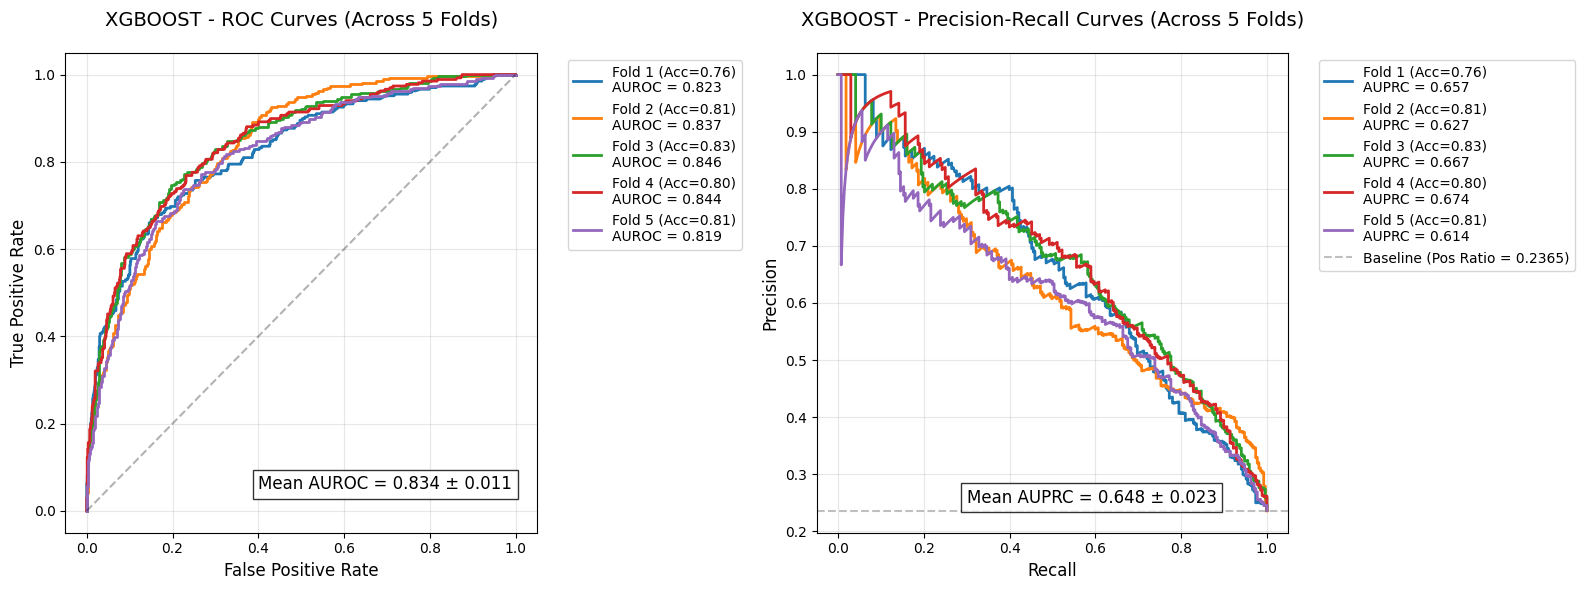

In [ ]:
def plot_model_performance(model_name, X, y, n_splits=5):
    """Plot performance metrics across all folds for a given model using the correct validation splits"""
    # Initialize lists to store metrics for all folds
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []
    all_accuracy = []
    all_auroc = []
    all_auprc = []
    fold_labels = []

    # Initialize cross-validation splitter
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Load each fold's model and compute metrics on its validation set
    save_folder = f'saved_models_{model_name}'

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Load model
        if model_name == 'xgboost':
            model_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.json')
            model = XGBClassifier()
            model.load_model(model_path)
        else:
            model_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.pkl')
            model = joblib.load(model_path)

        # Get the correct validation data for this fold
        X_val = X[val_idx]
        y_val = y[val_idx]

        # Get predictions
        y_pred = model.predict_proba(X_val)
        if y_pred.shape[1] == 2:  # binary classification
            y_pred = y_pred[:, 1]

        # Compute metrics
        fpr, tpr, _ = roc_curve(y_val, y_pred)
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        accuracy = accuracy_score(y_val, (y_pred > 0.5).astype(int))
        auroc = roc_auc_score(y_val, y_pred)
        auprc = average_precision_score(y_val, y_pred)

        # Store metrics
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_precision.append(precision)
        all_recall.append(recall)
        all_accuracy.append(accuracy)
        all_auroc.append(auroc)
        all_auprc.append(auprc)
        fold_labels.append(f'Fold {fold+1} (Acc={accuracy:.2f})')

    # Create figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot ROC curves
    plt.subplot(1, 2, 1)
    for i in range(n_splits):
        plt.plot(all_fpr[i], all_tpr[i],
                 label=f'{fold_labels[i]}\nAUROC = {all_auroc[i]:.3f}',
                 linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name.upper()} - ROC Curves (Across {n_splits} Folds)', fontsize=14, pad=20)

    # Add mean AUROC to the plot
    mean_auroc = np.mean(all_auroc)
    std_auroc = np.std(all_auroc)
    plt.text(0.4, 0.05,
             f'Mean AUROC = {mean_auroc:.3f} ± {std_auroc:.3f}',
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot PR curves
    plt.subplot(1, 2, 2)
    for i in range(n_splits):
        plt.plot(all_recall[i], all_precision[i],
                 label=f'{fold_labels[i]}\nAUPRC = {all_auprc[i]:.3f}',
                 linewidth=2)

    # Add baseline (positive class ratio)
    positive_ratio = np.mean(y)
    plt.axhline(y=positive_ratio, color='gray', linestyle='--', alpha=0.5,
                label=f'Baseline (Pos Ratio = {positive_ratio:.4f})')

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name.upper()} - Precision-Recall Curves (Across {n_splits} Folds)', fontsize=14, pad=20)

    # Add mean AUPRC to the plot
    mean_auprc = np.mean(all_auprc)
    std_auprc = np.std(all_auprc)
    plt.text(0.3, 0.25,
             f'Mean AUPRC = {mean_auprc:.3f} ± {std_auprc:.3f}',
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name}_performance_plots.png', dpi=1000, bbox_inches='tight')
    plt.show()
# Plot for each model and fold
plot_model_performance('xgboost', X, y)
# plot_model_performance('randomforest', X, y)

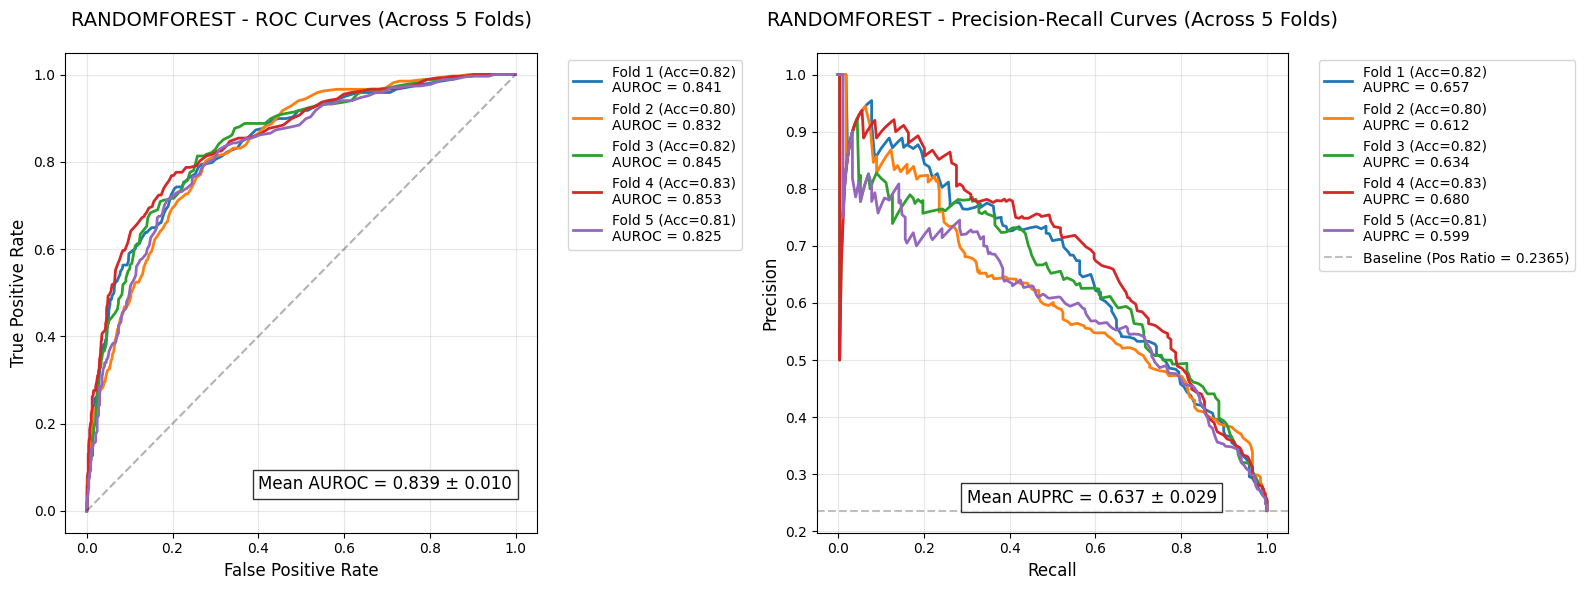

In [ ]:
plot_model_performance('randomforest', X, y)

# XGboost Interpretation - min_max


In [ ]:
def calculate_cluster_importance(feature_names, shap_values, num_clusters=20):
    """
    Calculate and visualize the importance of feature clusters.

    """
    # Compute mean absolute SHAP values for each feature
    mean_shap_values = np.abs(shap_values).mean(axis=0)

    # Reshape for clustering
    mean_shap_values = mean_shap_values.reshape(-1, 1)

    # Clustering features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(mean_shap_values)
    feature_clusters = kmeans.labels_

    # Calculate cluster importance by summing SHAP values within each cluster
    cluster_importance = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        cluster_importance[cluster] = mean_shap_values[cluster_indices].sum()

    # Normalize cluster importance
    total_importance = sum(cluster_importance.values())
    for cluster in cluster_importance:
        cluster_importance[cluster] /= total_importance

    # Visualization
    cluster_names = [f'Cluster {i+1}' for i in range(num_clusters)]
    cluster_values = [cluster_importance[i] for i in range(num_clusters)]

    plt.figure(figsize=(10,6))
    plt.barh(cluster_names, cluster_values, color='skyblue')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Clusters')
    plt.title('Feature Cluster Importance')
    plt.show()

    # Print cluster details
    print("Cluster details:")
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        print(f"\nCluster {cluster + 1} features:")
        for idx in cluster_indices:
            print(f"  {feature_names[idx]} (SHAP: {mean_shap_values[idx][0]:.4f})")



【XGBOOST】starting five fold cross validation - 2025-05-25 06:34:17
📊 original data distribution:
  negative: 4322 | positive: 1339
  positive percentage: 23.65%


🔍 per fold result：
  ✅ Fold 1: training 23.65% positive | validation 23.65% positive | difference: 0.00%
  ✅ Fold 2: training 23.67% positive | validation 23.59% positive | difference: 0.08%
  ✅ Fold 3: training 23.65% positive | validation 23.67% positive | difference: 0.03%
  ✅ Fold 4: training 23.65% positive | validation 23.67% positive | difference: 0.03%
  ✅ Fold 5: training 23.65% positive | validation 23.67% positive | difference: 0.03%

🏋️ training begin XGBOOST model...

🔄 FOLD 1/5 - 06:34:17
  training: 4528 | validation: 1133
  positive percentage in training: 23.65% | positive percentage in validation: 23.65%

⚙️ XGBoost parameter:
  n_estimators=200 | max_depth=6 | lr=0.05
  early_stopping=20 | eval_metric=[logloss, auc, aucpr]

⏳ training process:
[0]	validation_0-logloss:0.53300	validation_0-auc:0.83073	valid

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.38260	validation_0-auc:0.92454	validation_0-aucpr:0.84427	validation_1-logloss:0.44216	validation_1-auc:0.82274	validation_1-aucpr:0.64680
  LOGLOSS  final value: training=0.3768 | validation=0.4391
  AUC      final value: training=0.9266 | validation=0.8238
  AUCPR    final value: training=0.8474 | validation=0.6472

🎯 Fold 1 result:
  ⏱️ time: 0.3 seconds
  🎯 AUROC: 0.8226
  🎯 AUPRC: 0.6569
💾 model saved to: saved_models_xgboost/xgboost_fold_1.json


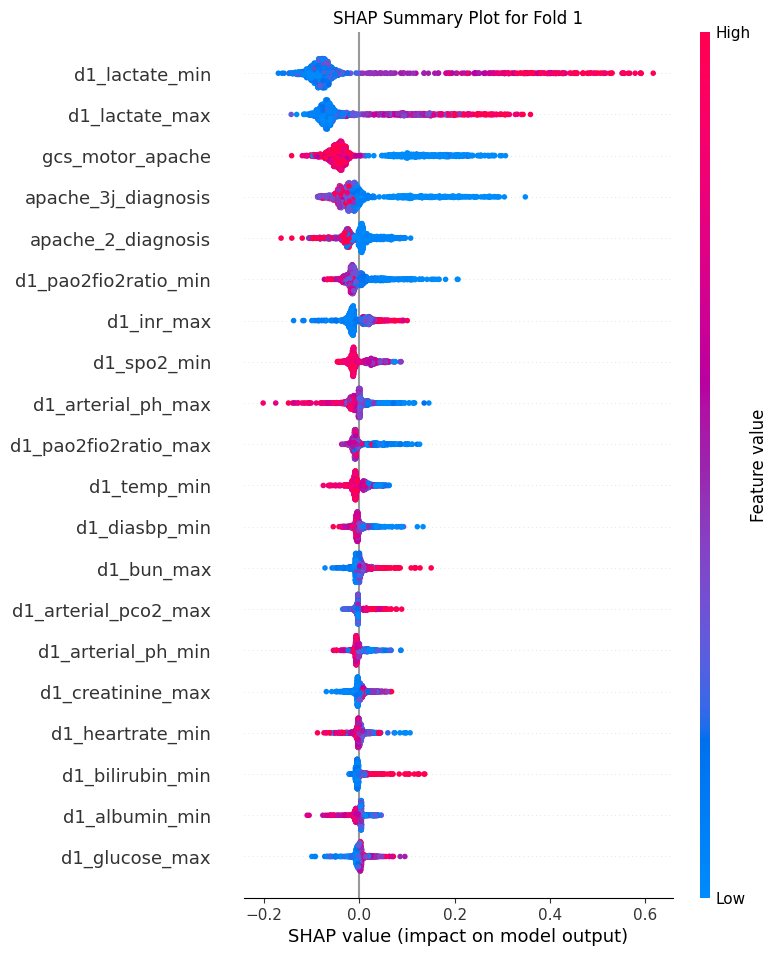

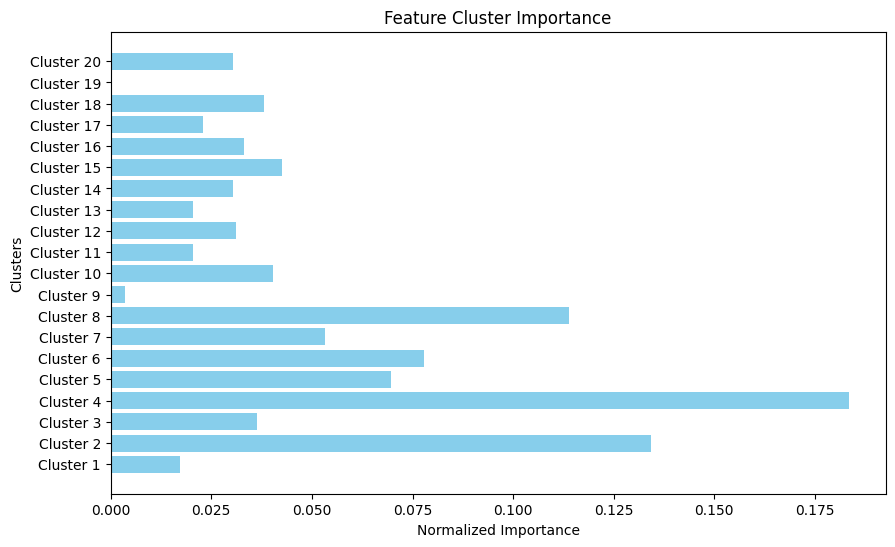

Cluster details:

Cluster 1 features:
  d1_glucose_min (SHAP: 0.0029)
  d1_mbp_max (SHAP: 0.0029)
  d1_resprate_max (SHAP: 0.0027)
  d1_sysbp_max (SHAP: 0.0028)

Cluster 2 features:
  d1_lactate_max (SHAP: 0.0876)

Cluster 3 features:
  d1_pao2fio2ratio_min (SHAP: 0.0238)

Cluster 4 features:
  d1_lactate_min (SHAP: 0.1197)

Cluster 5 features:
  apache_3j_diagnosis (SHAP: 0.0455)

Cluster 6 features:
  d1_albumin_min (SHAP: 0.0081)
  d1_arterial_pco2_max (SHAP: 0.0088)
  d1_arterial_ph_min (SHAP: 0.0087)
  d1_bilirubin_min (SHAP: 0.0083)
  d1_creatinine_max (SHAP: 0.0085)
  d1_heartrate_min (SHAP: 0.0085)

Cluster 7 features:
  d1_arterial_ph_max (SHAP: 0.0175)
  d1_pao2fio2ratio_max (SHAP: 0.0172)

Cluster 8 features:
  gcs_motor_apache (SHAP: 0.0744)

Cluster 9 features:
  d1_arterial_pco2_min (SHAP: 0.0004)
  d1_potassium_max (SHAP: 0.0006)
  d1_spo2_max (SHAP: 0.0009)
  diabetes_mellitus (SHAP: 0.0006)

Cluster 10 features:
  age (SHAP: 0.0058)
  d1_hco3_max (SHAP: 0.0051)
  d1_he

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:34:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.36379	validation_0-auc:0.92875	validation_0-aucpr:0.85900	validation_1-logloss:0.44231	validation_1-auc:0.82559	validation_1-aucpr:0.60981
[30]	validation_0-logloss:0.32198	validation_0-auc:0.94555	validation_0-aucpr:0.88414	validation_1-logloss:0.42628	validation_1-auc:0.83203	validation_1-aucpr:0.62074
[40]	validation_0-logloss:0.29223	validation_0-auc:0.95586	validation_0-aucpr:0.90272	validation_1-logloss:0.41811	validation_1-auc:0.83409	validation_1-aucpr:0.62176
[50]	validation_0-logloss:0.26713	validation_0-auc:0.96558	validation_0-aucpr:0.92077	validation_1-logloss:0.41204	validation_1-auc:0.83712	validation_1-aucpr:0.62560
[57]	validation_0-logloss:0.25205	validation_0-auc:0.97076	validation_0-aucpr:0.93125	validation_1-logloss:0.41065	validation_1-auc:0.83713	validation_1-aucpr:0.62471
  LOGLOSS  final value: training=0.2521 | validation=0.4106
  AUC      final value: training=0.9708 | validation=0.8371
  AUCPR    final value: training=0.9313 | val

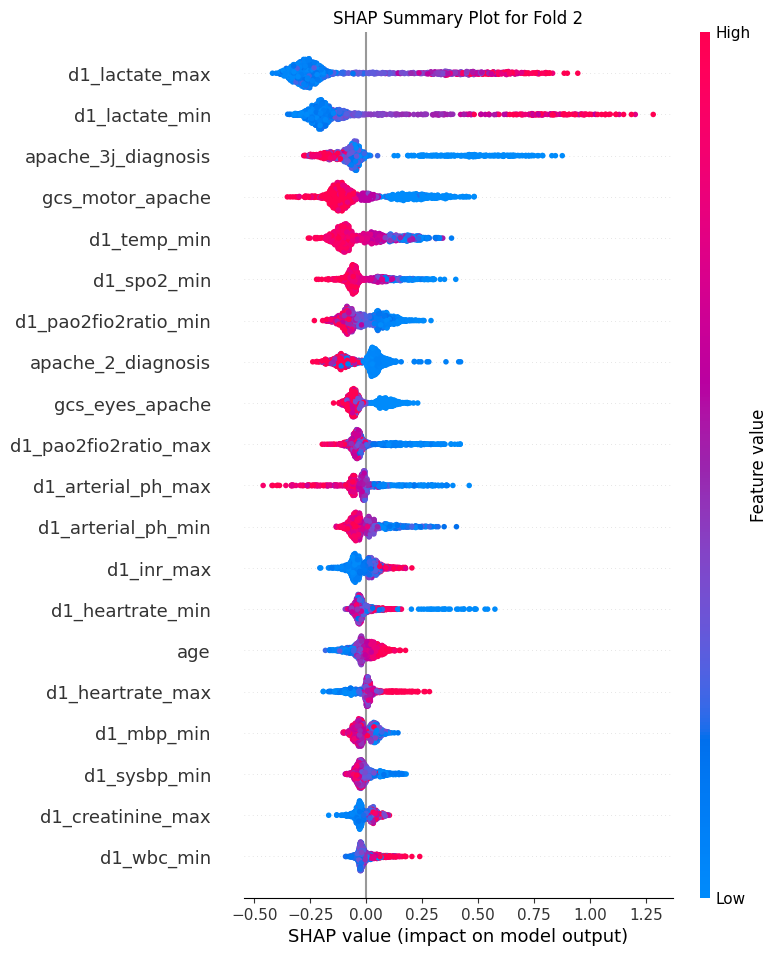

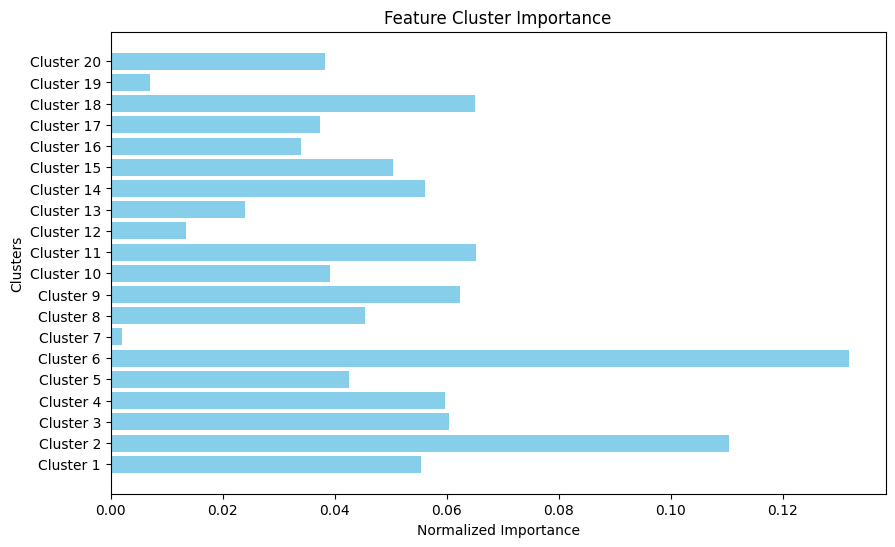

Cluster details:

Cluster 1 features:
  d1_albumin_min (SHAP: 0.0149)
  d1_bun_max (SHAP: 0.0146)
  d1_glucose_min (SHAP: 0.0131)
  d1_hco3_max (SHAP: 0.0155)
  d1_hematocrit_max (SHAP: 0.0147)
  d1_hematocrit_min (SHAP: 0.0145)
  d1_mbp_max (SHAP: 0.0131)
  d1_potassium_min (SHAP: 0.0138)
  d1_sodium_min (SHAP: 0.0152)

Cluster 2 features:
  d1_lactate_min (SHAP: 0.2578)

Cluster 3 features:
  apache_2_diagnosis (SHAP: 0.0715)
  gcs_eyes_apache (SHAP: 0.0695)

Cluster 4 features:
  gcs_motor_apache (SHAP: 0.1394)

Cluster 5 features:
  d1_creatinine_max (SHAP: 0.0338)
  d1_sysbp_min (SHAP: 0.0339)
  d1_wbc_min (SHAP: 0.0317)

Cluster 6 features:
  d1_lactate_max (SHAP: 0.3080)

Cluster 7 features:
  aids (SHAP: 0.0000)
  arf_apache (SHAP: 0.0000)
  cirrhosis (SHAP: 0.0002)
  elective_surgery (SHAP: 0.0000)
  gcs_unable_apache (SHAP: 0.0000)
  gcs_verbal_apache (SHAP: 0.0020)
  icu_admit_source (SHAP: 0.0024)
  lymphoma (SHAP: 0.0000)
  solid_tumor_with_metastasis (SHAP: 0.0000)
  vent

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:34:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.42951	validation_0-auc:0.91390	validation_0-aucpr:0.82400	validation_1-logloss:0.46087	validation_1-auc:0.84266	validation_1-aucpr:0.63831
[20]	validation_0-logloss:0.36807	validation_0-auc:0.93150	validation_0-aucpr:0.85710	validation_1-logloss:0.42710	validation_1-auc:0.84058	validation_1-aucpr:0.65731
[30]	validation_0-logloss:0.32637	validation_0-auc:0.94524	validation_0-aucpr:0.88308	validation_1-logloss:0.40907	validation_1-auc:0.84515	validation_1-aucpr:0.66047
[40]	validation_0-logloss:0.29280	validation_0-auc:0.95825	validation_0-aucpr:0.90565	validation_1-logloss:0.39927	validation_1-auc:0.84747	validation_1-aucpr:0.66181
[42]	validation_0-logloss:0.28783	validation_0-auc:0.96031	validation_0-aucpr:0.90925	validation_1-logloss:0.39823	validation_1-auc:0.84717	validation_1-aucpr:0.66525
  LOGLOSS  final value: training=0.2856 | validation=0.3970
  AUC      final value: training=0.9608 | validation=0.8483
  AUCPR    final value: training=0.9106 | val

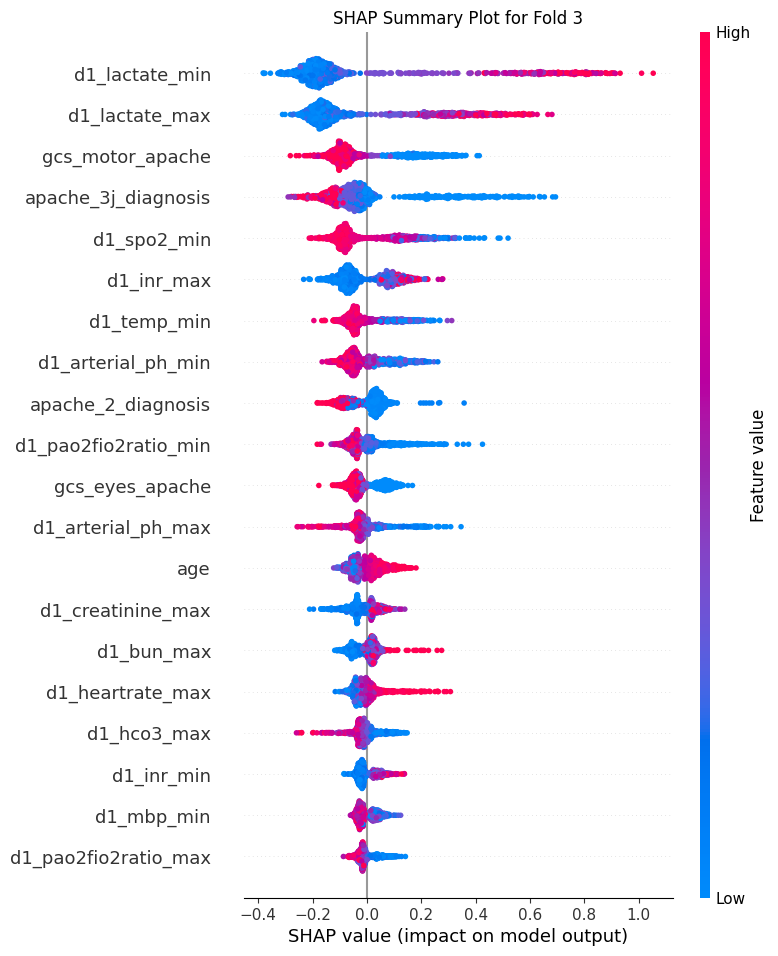

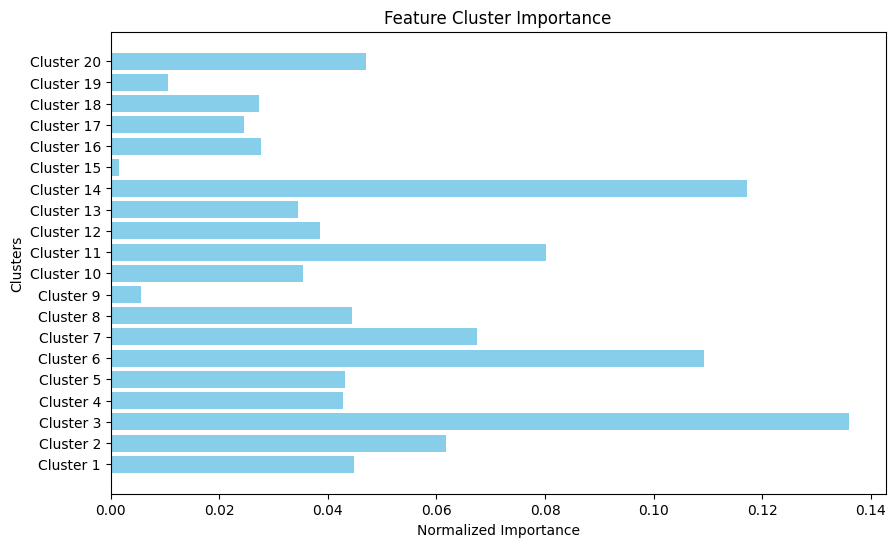

Cluster details:

Cluster 1 features:
  d1_albumin_max (SHAP: 0.0108)
  d1_bun_min (SHAP: 0.0095)
  d1_glucose_min (SHAP: 0.0100)
  d1_hematocrit_min (SHAP: 0.0092)
  d1_potassium_max (SHAP: 0.0086)
  d1_potassium_min (SHAP: 0.0093)
  d1_temp_max (SHAP: 0.0100)
  d1_wbc_min (SHAP: 0.0101)
  diabetes_mellitus (SHAP: 0.0092)

Cluster 2 features:
  gcs_motor_apache (SHAP: 0.1192)

Cluster 3 features:
  d1_lactate_min (SHAP: 0.2626)

Cluster 4 features:
  age (SHAP: 0.0422)
  d1_creatinine_max (SHAP: 0.0405)

Cluster 5 features:
  d1_bilirubin_min (SHAP: 0.0217)
  d1_diasbp_min (SHAP: 0.0196)
  d1_sysbp_max (SHAP: 0.0216)
  d1_sysbp_min (SHAP: 0.0207)

Cluster 6 features:
  d1_lactate_max (SHAP: 0.2111)

Cluster 7 features:
  d1_arterial_ph_min (SHAP: 0.0648)
  d1_temp_min (SHAP: 0.0656)

Cluster 8 features:
  d1_inr_max (SHAP: 0.0859)

Cluster 9 features:
  d1_resprate_max (SHAP: 0.0038)
  d1_sodium_min (SHAP: 0.0028)
  d1_spo2_max (SHAP: 0.0020)
  gcs_verbal_apache (SHAP: 0.0022)

Cluste

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:34:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.36697	validation_0-auc:0.93242	validation_0-aucpr:0.85963	validation_1-logloss:0.42724	validation_1-auc:0.84292	validation_1-aucpr:0.66955
[23]	validation_0-logloss:0.35294	validation_0-auc:0.93678	validation_0-aucpr:0.86668	validation_1-logloss:0.42073	validation_1-auc:0.84204	validation_1-aucpr:0.66812
  LOGLOSS  final value: training=0.3482 | validation=0.4188
  AUC      final value: training=0.9393 | validation=0.8418
  AUCPR    final value: training=0.8697 | validation=0.6679

🎯 Fold 4 result:
  ⏱️ time: 0.4 seconds
  🎯 AUROC: 0.8445
  🎯 AUPRC: 0.6740
💾 model saved to: saved_models_xgboost/xgboost_fold_4.json


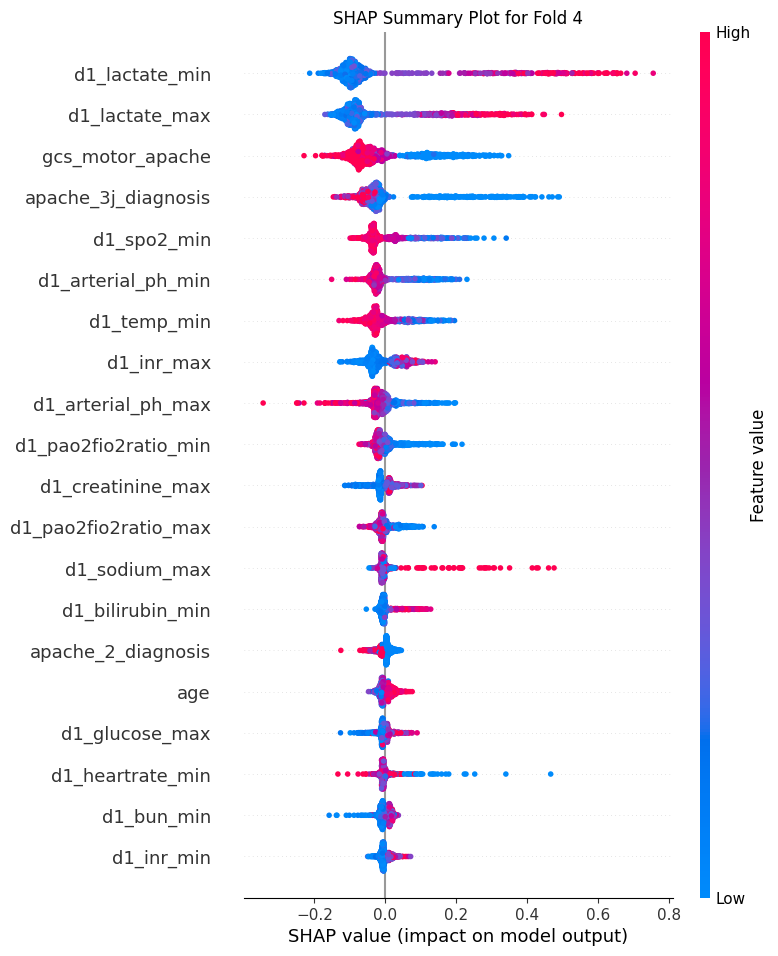

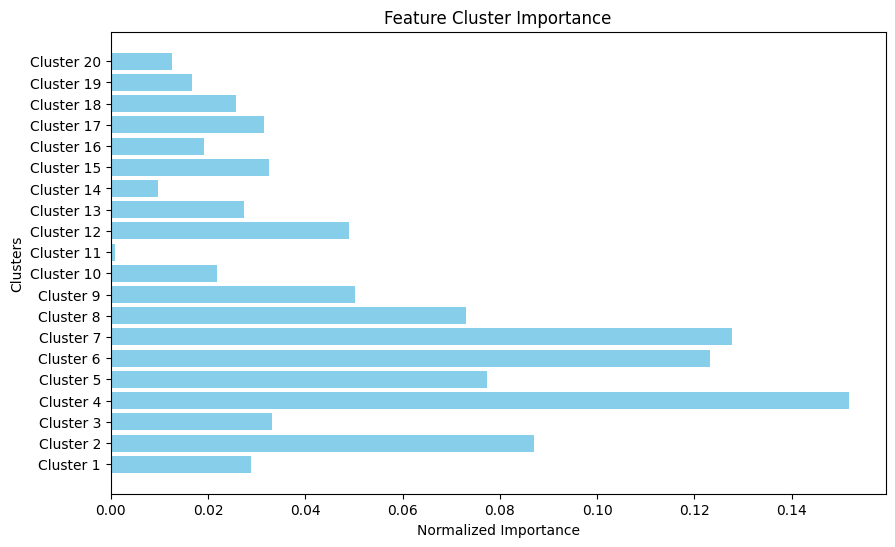

Cluster details:

Cluster 1 features:
  d1_arterial_po2_max (SHAP: 0.0032)
  d1_bilirubin_max (SHAP: 0.0033)
  d1_calcium_min (SHAP: 0.0029)
  d1_glucose_min (SHAP: 0.0031)
  d1_hco3_min (SHAP: 0.0028)
  d1_mbp_max (SHAP: 0.0032)
  d1_potassium_max (SHAP: 0.0037)
  d1_wbc_max (SHAP: 0.0033)
  d1_wbc_min (SHAP: 0.0028)

Cluster 2 features:
  gcs_motor_apache (SHAP: 0.0854)

Cluster 3 features:
  d1_arterial_ph_max (SHAP: 0.0324)

Cluster 4 features:
  d1_lactate_min (SHAP: 0.1488)

Cluster 5 features:
  age (SHAP: 0.0128)
  apache_2_diagnosis (SHAP: 0.0128)
  d1_bilirubin_min (SHAP: 0.0135)
  d1_bun_min (SHAP: 0.0119)
  d1_glucose_max (SHAP: 0.0125)
  d1_heartrate_min (SHAP: 0.0125)

Cluster 6 features:
  d1_lactate_max (SHAP: 0.1209)

Cluster 7 features:
  d1_arterial_ph_min (SHAP: 0.0422)
  d1_inr_max (SHAP: 0.0414)
  d1_temp_min (SHAP: 0.0416)

Cluster 8 features:
  apache_3j_diagnosis (SHAP: 0.0717)

Cluster 9 features:
  d1_arterial_po2_min (SHAP: 0.0077)
  d1_bun_max (SHAP: 0.0083

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:34:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.36226	validation_0-auc:0.93693	validation_0-aucpr:0.86097	validation_1-logloss:0.44192	validation_1-auc:0.81717	validation_1-aucpr:0.60951
[30]	validation_0-logloss:0.32122	validation_0-auc:0.94682	validation_0-aucpr:0.88335	validation_1-logloss:0.42846	validation_1-auc:0.82075	validation_1-aucpr:0.60664
  LOGLOSS  final value: training=0.3171 | validation=0.4277
  AUC      final value: training=0.9483 | validation=0.8199
  AUCPR    final value: training=0.8868 | validation=0.6051

🎯 Fold 5 result:
  ⏱️ time: 0.5 seconds
  🎯 AUROC: 0.8189
  🎯 AUPRC: 0.6136
💾 model saved to: saved_models_xgboost/xgboost_fold_5.json


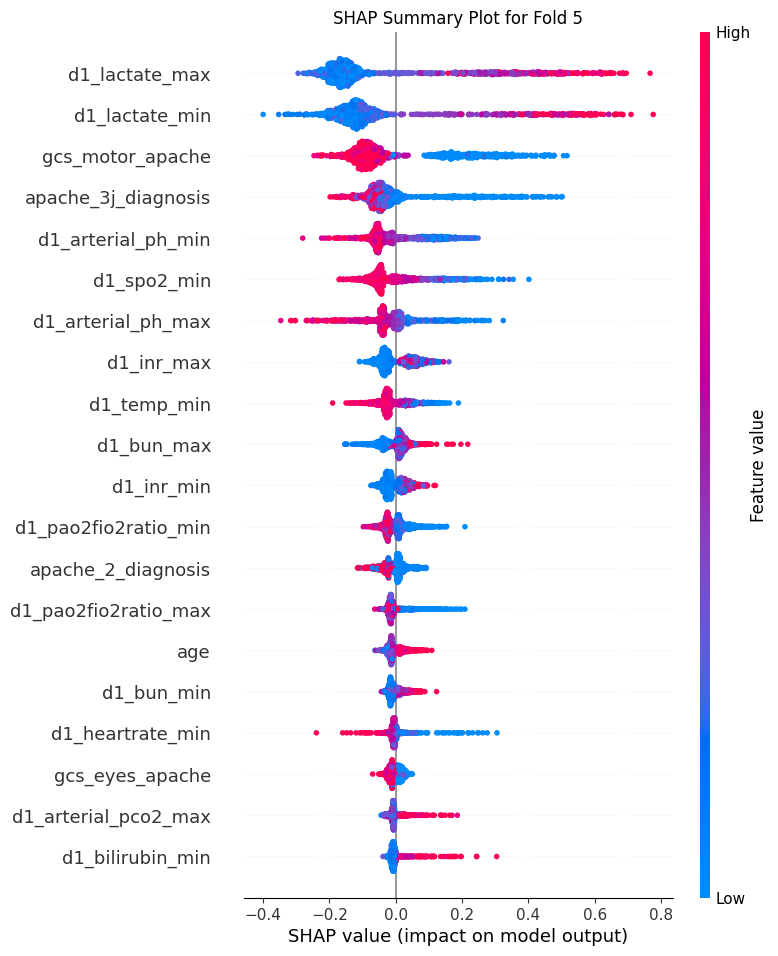

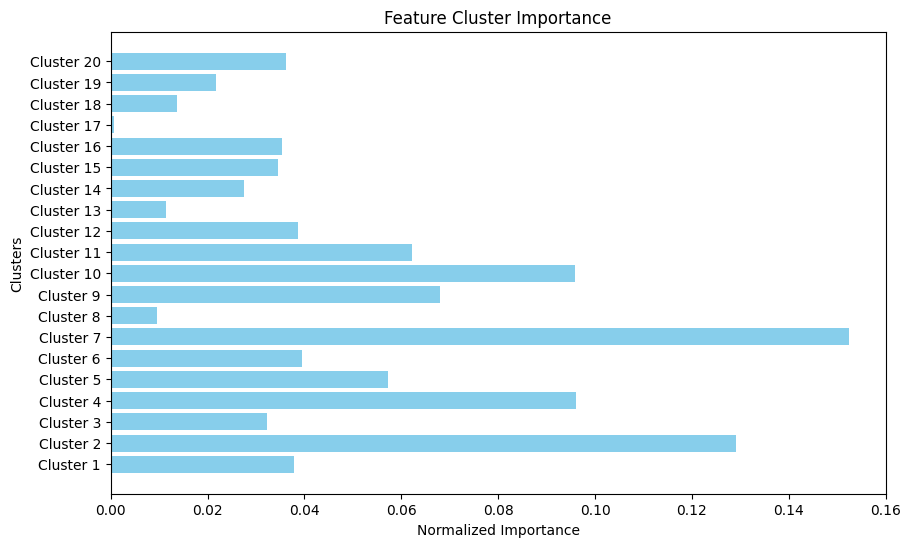

Cluster details:

Cluster 1 features:
  d1_albumin_max (SHAP: 0.0079)
  d1_creatinine_max (SHAP: 0.0082)
  d1_diasbp_min (SHAP: 0.0066)
  d1_glucose_min (SHAP: 0.0072)
  d1_mbp_min (SHAP: 0.0070)
  d1_platelets_max (SHAP: 0.0082)
  d1_resprate_max (SHAP: 0.0070)

Cluster 2 features:
  d1_lactate_min (SHAP: 0.1784)

Cluster 3 features:
  d1_inr_max (SHAP: 0.0447)

Cluster 4 features:
  gcs_motor_apache (SHAP: 0.1328)

Cluster 5 features:
  apache_3j_diagnosis (SHAP: 0.0793)

Cluster 6 features:
  d1_inr_min (SHAP: 0.0277)
  d1_pao2fio2ratio_min (SHAP: 0.0269)

Cluster 7 features:
  d1_lactate_max (SHAP: 0.2106)

Cluster 8 features:
  d1_arterial_pco2_min (SHAP: 0.0021)
  d1_calcium_max (SHAP: 0.0014)
  d1_hco3_min (SHAP: 0.0016)
  d1_hematocrit_max (SHAP: 0.0023)
  d1_potassium_min (SHAP: 0.0024)
  gcs_verbal_apache (SHAP: 0.0015)
  icu_admit_source (SHAP: 0.0021)

Cluster 9 features:
  d1_arterial_pco2_max (SHAP: 0.0154)
  d1_arterial_po2_min (SHAP: 0.0147)
  d1_bilirubin_min (SHAP: 0.

([np.float64(0.8226490380467604),
  np.float64(0.837028858435626),
  np.float64(0.8460345840243227),
  np.float64(0.8444884950248757),
  np.float64(0.8188571033720288)],
 [np.float64(0.6569171134685128),
  np.float64(0.627247418310088),
  np.float64(0.6671016817105626),
  np.float64(0.673961318266924),
  np.float64(0.613647854503629)])

In [ ]:
def run_cv_with_model(X, y, model_name='xgboost', feature_names=None, num_clusters=20):
    """with 5 fold cross validation"""

    print("\n" + "="*60)
    print(f"【{model_name.upper()}】starting five fold cross validation - {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*60)
    print("📊 original data distribution:")
    print(f"  negative: {np.sum(y == 0)} | positive: {np.sum(y == 1)}")
    print(f"  positive percentage: {np.mean(y):.2%}\n")

    # data check
    assert len(X) == len(y), "❌ size between features and labels！"
    assert not np.isnan(y).any(), "❌ include missing data！"
    assert len(np.unique(y)) > 1, "❌ only one type of label！"

    # ================== initialize 5 fold cross validation ==================
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # ================== for each fold ==================
    print("\n🔍 per fold result：")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        y_train, y_val = y[train_idx], y[val_idx]
        diff = abs(y_train.mean() - y_val.mean()) * 100
        status = "✅" if diff < 1 else "❌"
        print(f"  {status} Fold {fold + 1}: training {y_train.mean():.2%} positive | "
              f"validation {y_val.mean():.2%} positive | difference: {diff:.2f}%")

    # ================== initialize output [] ==================
    auroc_scores = []
    auprc_scores = []
    training_times = []
    fold_models = []

    # ================== for training ==================
    print(f"\n🏋️ training begin {model_name.upper()} model...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold_start_time = time.time()
        print("\n" + "="*60)
        print(f"🔄 FOLD {fold + 1}/{n_splits} - {time.strftime('%H:%M:%S')}")
        print(f"  training: {len(train_idx)} | validation: {len(val_idx)}")
        print(f"  positive percentage in training: {y[train_idx].mean():.2%} | positive percentage in validation: {y[val_idx].mean():.2%}")
        print("="*60)

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if model_name == 'xgboost':
            model = XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42 + fold,
                use_label_encoder=False,
                eval_metric=['logloss', 'auc', 'aucpr'],
                early_stopping_rounds=10,
                verbosity=1
            )
            print("\n⚙️ XGBoost parameter:")
            print(f"  n_estimators=200 | max_depth=6 | lr=0.05")
            print(f"  early_stopping=20 | eval_metric=[logloss, auc, aucpr]")

        elif model_name == 'randomforest':
            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=42 + fold,
                class_weight='balanced',
                verbose=0,
                n_jobs=-1
            )
            print("\n⚙️ Random Forest parameter:")
            print(f"  n_estimators=200 | max_depth=None")
            print(f"  class_weight=balanced | n_jobs=-1")

        # ========== print training process ==========
        print("\n⏳ training process:")
        if model_name == 'xgboost':
            # for XGboost
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                verbose=10  # output per 10 epochs
            )

            # print the output
            results = model.evals_result()
            for i, metric in enumerate(['logloss', 'auc', 'aucpr']):
                print(f"  {metric.upper():<8} final value: "
                      f"training={results['validation_0'][metric][-1]:.4f} | "
                      f"validation={results['validation_1'][metric][-1]:.4f}")
        else:
            # Random Forest training
            print("  RF training begins")
            with tqdm(total=model.n_estimators, desc="tree building") as pbar:
                model.fit(X_train, y_train)
                pbar.update(model.n_estimators)

            # output the tree built process
            print("\n🌲 tree built completed:")
            print(f"  number of trees built: {len(model.estimators_)}")
            print(f"  average depth of each tree: "
                  f"{np.mean([tree.tree_.max_depth for tree in model.estimators_]):.1f}")

        # ========== evaluate the model ==========
        fold_time = time.time() - fold_start_time
        training_times.append(fold_time)

        preds = model.predict_proba(X_val)

        if preds.shape[1] == 2:  # binary classification
            preds = preds[:, 1]
            auroc = roc_auc_score(y_val, preds)
            auprc = average_precision_score(y_val, preds)
        else:  # multiple classification
            auroc = roc_auc_score(y_val, preds, multi_class='ovr')
            auprc = average_precision_score(y_val, preds, average='macro')

        print(f"\n🎯 Fold {fold + 1} result:")
        print(f"  ⏱️ time: {fold_time:.1f} seconds")
        print(f"  🎯 AUROC: {auroc:.4f}")
        print(f"  🎯 AUPRC: {auprc:.4f}")

        auroc_scores.append(auroc)
        auprc_scores.append(auprc)
        fold_models.append(model)

        # ========== model save ==========
        save_folder = f'saved_models_{model_name}'
        os.makedirs(save_folder, exist_ok=True)

        if model_name == 'xgboost':
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.json')
            model.save_model(model_save_path)
        else:
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.pkl')
            joblib.dump(model, model_save_path)

        print(f"💾 model saved to: {model_save_path}")

        # ========== SHAP plotting and cluster importance calculation ==========
        if model_name in ['xgboost', 'randomforest']:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_val)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # For binary classification

            # Plot SHAP summary
            plt.figure()
            shap.summary_plot(shap_values, X_val, feature_names=feature_names, show=False)
            plt.title(f'SHAP Summary Plot for Fold {fold+1}')
            plt.savefig(os.path.join(save_folder, f'shap_fold_{fold+1}.png'), dpi=300, bbox_inches='tight')
            plt.show()

            calculate_cluster_importance(feature_names, shap_values, num_clusters = num_clusters)

    # ================== final report ==================
    print("\n\n" + "="*60)
    print(f"🔥 {model_name.upper()} final result - average training time: {np.mean(training_times):.1f} seconds per fold")
    print("="*60)
    print(f"📊 Avg AUROC: {np.mean(auroc_scores):.4f} ± {np.std(auroc_scores):.4f}")
    print(f"📊 Avg AUPRC: {np.mean(auprc_scores):.4f} ± {np.std(auprc_scores):.4f}")

    print("\n📝 results for each fold:")
    for fold in range(n_splits):
        print(f"  Fold {fold + 1}: "
              f"AUROC={auroc_scores[fold]:.4f} | "
              f"AUPRC={auprc_scores[fold]:.4f} | "
              f"time consumed={training_times[fold]:.1f} s")

    print(f"\n💾 all models are saved to : {save_folder}/")
    return auroc_scores, auprc_scores

# Example usage:

# Assuming X, y, and feature_names are already defined
feature_names = df_encoded[features].columns.tolist()
run_cv_with_model(X, y, 'xgboost', feature_names = feature_names, num_clusters = 20)

# RF train and interpretation -min_max

In [ ]:
def calculate_cluster_importance(feature_names, importances, num_clusters=20):
    """
    Calculate and visualize the importance of feature clusters based on feature importances.
    """
    # Compute mean absolute feature importances
    mean_importances = np.abs(importances)

    # Reshape for clustering
    mean_importances = mean_importances.reshape(-1, 1)

    # Clustering features
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(mean_importances)
    feature_clusters = kmeans.labels_

    # Calculate cluster importance by summing feature importances within each cluster
    cluster_importance = {}
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        cluster_importance[cluster] = mean_importances[cluster_indices].sum()

    # Normalize cluster importance
    total_importance = sum(cluster_importance.values())
    for cluster in cluster_importance:
        cluster_importance[cluster] /= total_importance

    # Visualization
    cluster_names = [f'Cluster {i+1}' for i in range(num_clusters)]
    cluster_values = [cluster_importance[i] for i in range(num_clusters)]

    plt.figure(figsize=(10, 6))
    plt.barh(cluster_names, cluster_values, color='skyblue')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Clusters')
    plt.title('Feature Cluster Importance')
    plt.show()

    # Print cluster details
    print("Cluster details:")
    for cluster in range(num_clusters):
        cluster_indices = np.where(feature_clusters == cluster)[0]
        print(f"\nCluster {cluster + 1} features:")
        for idx in cluster_indices:
            print(f"  {feature_names[idx]} (Importance: {mean_importances[idx][0]:.4f})")

    return cluster_importance


【RANDOMFOREST】starting five fold cross validation - 2025-05-25 06:34:36
📊 original data distribution:
  negative: 4322 | positive: 1339
  positive percentage: 23.65%


🔍 per fold result：
  ✅ Fold 1: training 23.65% positive | validation 23.65% positive | difference: 0.00%
  ✅ Fold 2: training 23.67% positive | validation 23.59% positive | difference: 0.08%
  ✅ Fold 3: training 23.65% positive | validation 23.67% positive | difference: 0.03%
  ✅ Fold 4: training 23.65% positive | validation 23.67% positive | difference: 0.03%
  ✅ Fold 5: training 23.65% positive | validation 23.67% positive | difference: 0.03%

🏋️ training begin RANDOMFOREST model...

🔄 FOLD 1/5 - 06:34:36
  training: 4528 | validation: 1133
  positive percentage in training: 23.65% | positive percentage in validation: 23.65%

⚙️ Random Forest parameter:
  n_estimators=200 | max_depth=None
  class_weight=balanced | n_jobs=-1

⏳ training process:
  RF training begins


tree building: 100%|██████████| 200/200 [00:05<00:00, 39.68it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 22.4

🎯 Fold 1 result:
  ⏱️ time: 5.0 seconds
  🎯 AUROC: 0.8407
  🎯 AUPRC: 0.6570

🔥 Top 20 Important Features for Fold 1:

                      Importance
d1_lactate_min          0.059970
d1_lactate_max          0.056767
d1_arterial_ph_min      0.033503
d1_temp_min             0.032639
apache_3j_diagnosis     0.031893
d1_inr_max              0.029873
d1_spo2_min             0.025509
d1_pao2fio2ratio_min    0.025006
gcs_motor_apache        0.020215
d1_creatinine_max       0.019274
d1_hco3_min             0.018459
d1_inr_min              0.018097
d1_sysbp_min            0.017960
d1_mbp_min              0.017784
d1_pao2fio2ratio_max    0.017687
d1_bun_max              0.017060
d1_arterial_ph_max      0.016683
d1_temp_max             0.016628
d1_creatinine_min       0.016464
d1_heartrate_max        0.016258


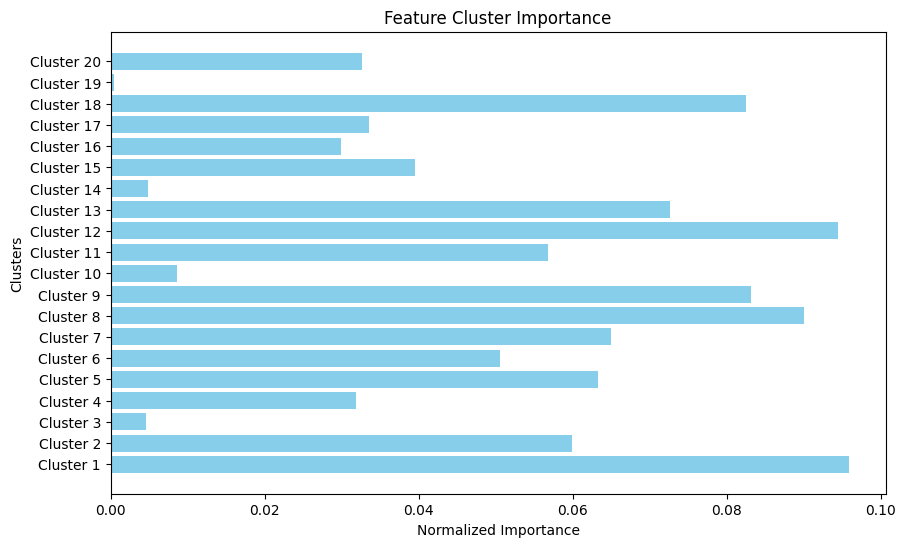

Cluster details:

Cluster 1 features:
  apache_2_diagnosis (Importance: 0.0161)
  d1_arterial_po2_min (Importance: 0.0159)
  d1_diasbp_min (Importance: 0.0162)
  d1_glucose_max (Importance: 0.0162)
  d1_glucose_min (Importance: 0.0157)
  d1_heartrate_min (Importance: 0.0157)

Cluster 2 features:
  d1_lactate_min (Importance: 0.0600)

Cluster 3 features:
  arf_apache (Importance: 0.0007)
  cirrhosis (Importance: 0.0008)
  elective_surgery (Importance: 0.0012)
  solid_tumor_with_metastasis (Importance: 0.0006)
  ventilated_apache (Importance: 0.0013)

Cluster 4 features:
  apache_3j_diagnosis (Importance: 0.0319)

Cluster 5 features:
  d1_calcium_max (Importance: 0.0105)
  d1_calcium_min (Importance: 0.0109)
  d1_potassium_max (Importance: 0.0104)
  d1_potassium_min (Importance: 0.0105)
  d1_resprate_min (Importance: 0.0104)
  d1_sodium_min (Importance: 0.0106)

Cluster 6 features:
  d1_pao2fio2ratio_min (Importance: 0.0250)
  d1_spo2_min (Importance: 0.0255)

Cluster 7 features:
  d1_bi

tree building: 100%|██████████| 200/200 [00:03<00:00, 61.14it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 22.6

🎯 Fold 2 result:
  ⏱️ time: 3.3 seconds
  🎯 AUROC: 0.8316
  🎯 AUPRC: 0.6119

🔥 Top 20 Important Features for Fold 2:

                      Importance
d1_lactate_max          0.068073
d1_lactate_min          0.062911
d1_arterial_ph_min      0.035440
d1_temp_min             0.033304
apache_3j_diagnosis     0.032716
gcs_motor_apache        0.022894
d1_spo2_min             0.022138
d1_pao2fio2ratio_min    0.022066
d1_inr_max              0.021731
d1_sysbp_min            0.020246
d1_hco3_min             0.019052
apache_2_diagnosis      0.018850
d1_creatinine_max       0.018345
d1_arterial_ph_max      0.018214
d1_mbp_min              0.017339
d1_inr_min              0.017038
d1_pao2fio2ratio_max    0.017021
d1_temp_max             0.016626
d1_heartrate_min        0.016086
d1_glucose_max          0.015732


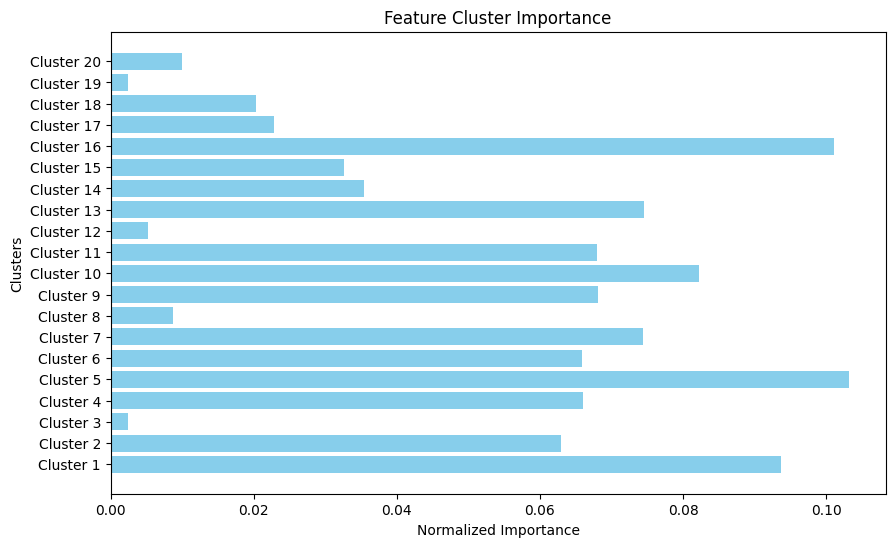

Cluster details:

Cluster 1 features:
  d1_arterial_po2_min (Importance: 0.0154)
  d1_glucose_max (Importance: 0.0157)
  d1_glucose_min (Importance: 0.0152)
  d1_heartrate_max (Importance: 0.0156)
  d1_heartrate_min (Importance: 0.0161)
  d1_wbc_min (Importance: 0.0155)

Cluster 2 features:
  d1_lactate_min (Importance: 0.0629)

Cluster 3 features:
  aids (Importance: 0.0002)
  arf_apache (Importance: 0.0005)
  cirrhosis (Importance: 0.0006)
  gcs_unable_apache (Importance: 0.0000)
  lymphoma (Importance: 0.0003)
  solid_tumor_with_metastasis (Importance: 0.0008)

Cluster 4 features:
  apache_3j_diagnosis (Importance: 0.0327)
  d1_temp_min (Importance: 0.0333)

Cluster 5 features:
  d1_arterial_pco2_min (Importance: 0.0118)
  d1_bilirubin_min (Importance: 0.0116)
  d1_calcium_min (Importance: 0.0114)
  d1_hemaglobin_max (Importance: 0.0115)
  d1_hemaglobin_min (Importance: 0.0112)
  d1_hematocrit_min (Importance: 0.0115)
  d1_potassium_max (Importance: 0.0113)
  d1_potassium_min (Impor

tree building: 100%|██████████| 200/200 [00:03<00:00, 60.97it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 22.4

🎯 Fold 3 result:
  ⏱️ time: 3.3 seconds
  🎯 AUROC: 0.8446
  🎯 AUPRC: 0.6343

🔥 Top 20 Important Features for Fold 3:

                      Importance
d1_lactate_max          0.057021
d1_lactate_min          0.053023
d1_arterial_ph_min      0.037073
d1_temp_min             0.028959
apache_3j_diagnosis     0.028847
d1_inr_max              0.026703
d1_spo2_min             0.025301
gcs_motor_apache        0.024292
d1_hco3_min             0.023611
d1_pao2fio2ratio_min    0.022882
d1_creatinine_max       0.021153
d1_inr_min              0.020516
d1_sysbp_min            0.018468
d1_arterial_ph_max      0.017077
d1_temp_max             0.016849
d1_heartrate_max        0.016747
d1_mbp_min              0.016599
d1_bun_max              0.016597
d1_glucose_max          0.016578
d1_diasbp_min           0.016393


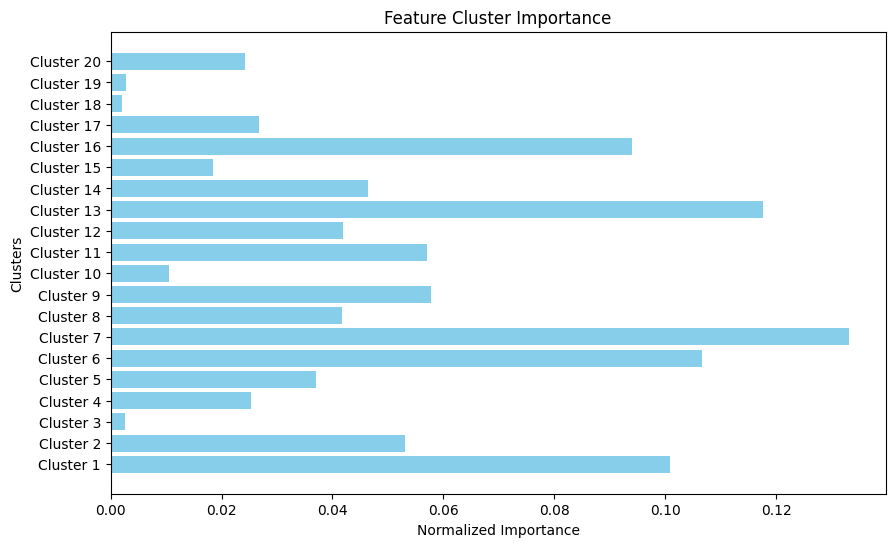

Cluster details:

Cluster 1 features:
  apache_2_diagnosis (Importance: 0.0144)
  d1_arterial_pco2_max (Importance: 0.0144)
  d1_bilirubin_max (Importance: 0.0139)
  d1_glucose_min (Importance: 0.0143)
  d1_platelets_min (Importance: 0.0148)
  d1_sysbp_max (Importance: 0.0145)
  d1_wbc_min (Importance: 0.0145)

Cluster 2 features:
  d1_lactate_min (Importance: 0.0530)

Cluster 3 features:
  aids (Importance: 0.0002)
  arf_apache (Importance: 0.0006)
  cirrhosis (Importance: 0.0008)
  gcs_unable_apache (Importance: 0.0000)
  lymphoma (Importance: 0.0004)
  solid_tumor_with_metastasis (Importance: 0.0007)

Cluster 4 features:
  d1_spo2_min (Importance: 0.0253)

Cluster 5 features:
  d1_arterial_ph_min (Importance: 0.0371)

Cluster 6 features:
  d1_bilirubin_min (Importance: 0.0114)
  d1_hemaglobin_max (Importance: 0.0117)
  d1_hemaglobin_min (Importance: 0.0119)
  d1_hematocrit_max (Importance: 0.0123)
  d1_hematocrit_min (Importance: 0.0124)
  d1_potassium_max (Importance: 0.0118)
  d1_

tree building: 100%|██████████| 200/200 [00:03<00:00, 50.29it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 22.8

🎯 Fold 4 result:
  ⏱️ time: 4.0 seconds
  🎯 AUROC: 0.8527
  🎯 AUPRC: 0.6800

🔥 Top 20 Important Features for Fold 4:

                      Importance
d1_lactate_max          0.058436
d1_lactate_min          0.057212
d1_temp_min             0.035558
d1_arterial_ph_min      0.033902
apache_3j_diagnosis     0.030307
d1_inr_max              0.026803
gcs_motor_apache        0.025560
d1_spo2_min             0.024998
d1_pao2fio2ratio_min    0.022529
d1_creatinine_max       0.022356
d1_hco3_min             0.020778
d1_pao2fio2ratio_max    0.018666
d1_inr_min              0.018144
d1_arterial_po2_min     0.017977
d1_arterial_ph_max      0.017557
d1_mbp_min              0.017398
d1_heartrate_min        0.016853
d1_temp_max             0.016646
d1_creatinine_min       0.016429
apache_2_diagnosis      0.016366


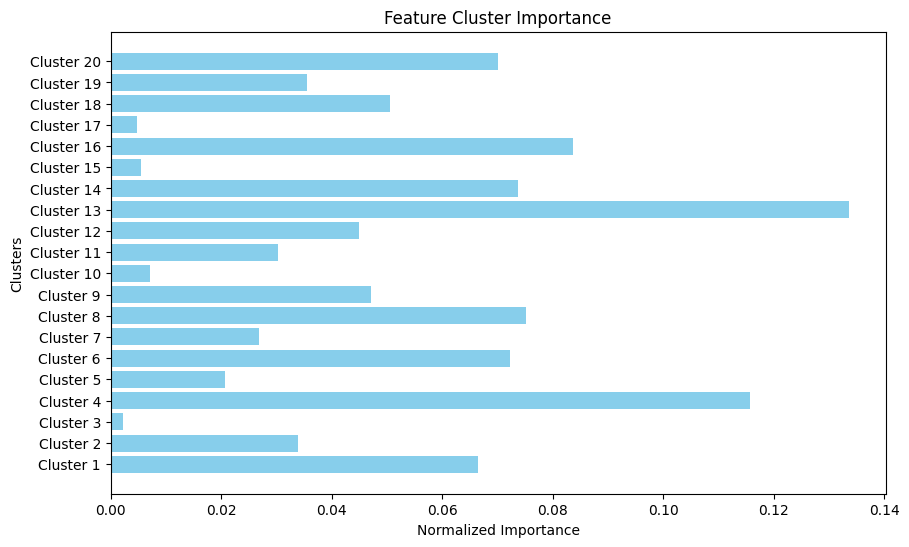

Cluster details:

Cluster 1 features:
  d1_arterial_po2_max (Importance: 0.0136)
  d1_glucose_min (Importance: 0.0134)
  d1_wbc_max (Importance: 0.0131)
  d1_wbc_min (Importance: 0.0130)
  gcs_eyes_apache (Importance: 0.0134)

Cluster 2 features:
  d1_arterial_ph_min (Importance: 0.0339)

Cluster 3 features:
  aids (Importance: 0.0001)
  arf_apache (Importance: 0.0006)
  cirrhosis (Importance: 0.0007)
  gcs_unable_apache (Importance: 0.0000)
  lymphoma (Importance: 0.0004)
  solid_tumor_with_metastasis (Importance: 0.0005)

Cluster 4 features:
  d1_lactate_max (Importance: 0.0584)
  d1_lactate_min (Importance: 0.0572)

Cluster 5 features:
  d1_hco3_min (Importance: 0.0208)

Cluster 6 features:
  d1_arterial_ph_max (Importance: 0.0176)
  d1_arterial_po2_min (Importance: 0.0180)
  d1_inr_min (Importance: 0.0181)
  d1_pao2fio2ratio_max (Importance: 0.0187)

Cluster 7 features:
  d1_inr_max (Importance: 0.0268)

Cluster 8 features:
  d1_albumin_max (Importance: 0.0102)
  d1_albumin_min (Im

tree building: 100%|██████████| 200/200 [00:04<00:00, 45.35it/s]



🌲 tree built completed:
  number of trees built: 200
  average depth of each tree: 22.5

🎯 Fold 5 result:
  ⏱️ time: 4.4 seconds
  🎯 AUROC: 0.8255
  🎯 AUPRC: 0.5994

🔥 Top 20 Important Features for Fold 5:

                      Importance
d1_lactate_max          0.059397
d1_lactate_min          0.056243
d1_arterial_ph_min      0.039089
apache_3j_diagnosis     0.030385
d1_spo2_min             0.029691
d1_temp_min             0.029065
d1_inr_max              0.026939
gcs_motor_apache        0.026532
d1_pao2fio2ratio_min    0.023731
d1_creatinine_max       0.021186
d1_arterial_ph_max      0.020006
d1_hco3_min             0.019323
d1_inr_min              0.018519
d1_temp_max             0.017905
d1_mbp_min              0.017444
d1_pao2fio2ratio_max    0.017149
d1_bun_max              0.016973
d1_heartrate_min        0.016781
d1_heartrate_max        0.016379
d1_sysbp_min            0.016345


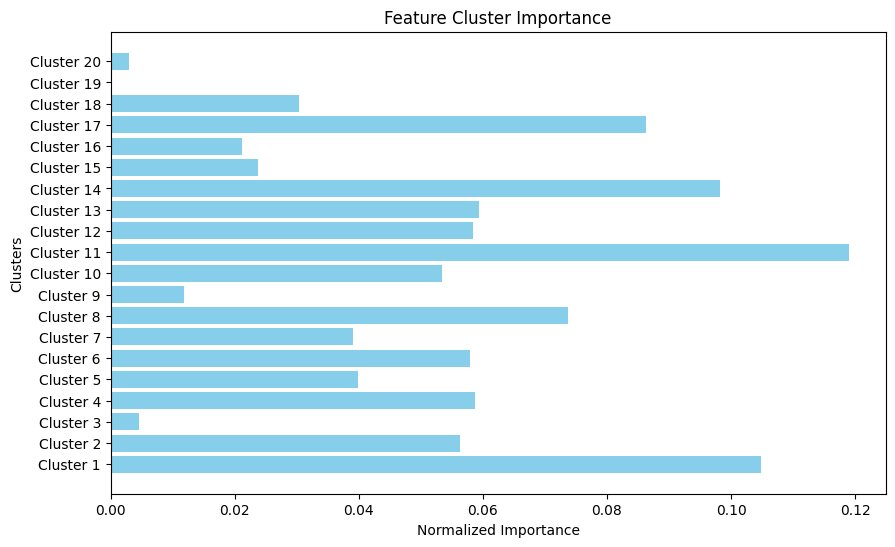

Cluster details:

Cluster 1 features:
  d1_arterial_po2_min (Importance: 0.0151)
  d1_bun_min (Importance: 0.0149)
  d1_creatinine_min (Importance: 0.0148)
  d1_glucose_max (Importance: 0.0149)
  d1_glucose_min (Importance: 0.0149)
  d1_platelets_max (Importance: 0.0157)
  d1_wbc_max (Importance: 0.0146)

Cluster 2 features:
  d1_lactate_min (Importance: 0.0562)

Cluster 3 features:
  arf_apache (Importance: 0.0006)
  cirrhosis (Importance: 0.0008)
  elective_surgery (Importance: 0.0013)
  solid_tumor_with_metastasis (Importance: 0.0007)
  ventilated_apache (Importance: 0.0012)

Cluster 4 features:
  d1_spo2_min (Importance: 0.0297)
  d1_temp_min (Importance: 0.0291)

Cluster 5 features:
  apache_2_diagnosis (Importance: 0.0136)
  d1_bilirubin_max (Importance: 0.0133)
  d1_diasbp_max (Importance: 0.0130)

Cluster 6 features:
  d1_arterial_ph_max (Importance: 0.0200)
  d1_hco3_min (Importance: 0.0193)
  d1_inr_min (Importance: 0.0185)

Cluster 7 features:
  d1_arterial_ph_min (Importanc

([np.float64(0.8407428177033904),
  np.float64(0.8315645905046438),
  np.float64(0.8446482863460475),
  np.float64(0.8527091106965174),
  np.float64(0.8254560530679934)],
 [np.float64(0.6570486327909454),
  np.float64(0.6118753114129416),
  np.float64(0.6342870959311213),
  np.float64(0.6800116716737802),
  np.float64(0.5993513131796488)])

In [ ]:
def run_cv_with_model(X, y, model_name='xgboost', feature_names = None, num_clusters = 20):
    """with 5 fold cross validation"""

    print("\n" + "="*60)
    print(f"【{model_name.upper()}】starting five fold cross validation - {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*60)
    print("📊 original data distribution:")
    print(f"  negative: {np.sum(y == 0)} | positive: {np.sum(y == 1)}")
    print(f"  positive percentage: {np.mean(y):.2%}\n")

    # data check
    assert len(X) == len(y), "❌ size between features and labels！"
    assert not np.isnan(y).any(), "❌ include missing data！"
    assert len(np.unique(y)) > 1, "❌ only one type of label！"

    # ================== initialize 5 fold cross validation ==================
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # ================== for each fold ==================
    print("\n🔍 per fold result：")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        y_train, y_val = y[train_idx], y[val_idx]
        diff = abs(y_train.mean() - y_val.mean()) * 100
        status = "✅" if diff < 1 else "❌"
        print(f"  {status} Fold {fold + 1}: training {y_train.mean():.2%} positive | "
              f"validation {y_val.mean():.2%} positive | difference: {diff:.2f}%")

    # ================== initialize output [] ==================
    auroc_scores = []
    auprc_scores = []
    training_times = []
    fold_models = []
    feature_importances_per_fold = []

    # ================== for training ==================
    print(f"\n🏋️ training begin {model_name.upper()} model...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold_start_time = time.time()
        print("\n" + "="*60)
        print(f"🔄 FOLD {fold + 1}/{n_splits} - {time.strftime('%H:%M:%S')}")
        print(f"  training: {len(train_idx)} | validation: {len(val_idx)}")
        print(f"  positive percentage in training: {y[train_idx].mean():.2%} | positive percentage in validation: {y[val_idx].mean():.2%}")
        print("="*60)

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if model_name == 'xgboost':
            model = XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42 + fold,
                use_label_encoder=False,
                eval_metric=['logloss', 'auc', 'aucpr'],
                early_stopping_rounds=10,
                verbosity=1
            )
            print("\n⚙️ XGBoost parameter:")
            print(f"  n_estimators=200 | max_depth=6 | lr=0.05")
            print(f"  early_stopping=20 | eval_metric=[logloss, auc, aucpr]")

        elif model_name == 'randomforest':
            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=42 + fold,
                class_weight='balanced',
                verbose=0,
                n_jobs=-1
            )
            print("\n⚙️ Random Forest parameter:")
            print(f"  n_estimators=200 | max_depth=None")
            print(f"  class_weight=balanced | n_jobs=-1")

        # ========== print training process ==========
        print("\n⏳ training process:")
        if model_name == 'xgboost':
            # for XGboost
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                verbose=10  # output per 10 epochs
            )

            # print the output
            results = model.evals_result()
            for i, metric in enumerate(['logloss', 'auc', 'aucpr']):
                print(f"  {metric.upper():<8} final value: "
                      f"training={results['validation_0'][metric][-1]:.4f} | "
                      f"validation={results['validation_1'][metric][-1]:.4f}")
        else:
            # Random Forest training
            print("  RF training begins")
            with tqdm(total=model.n_estimators, desc="tree building") as pbar:
                model.fit(X_train, y_train)
                pbar.update(model.n_estimators)

            # output the tree built process
            print("\n🌲 tree built completed:")
            print(f"  number of trees built: {len(model.estimators_)}")
            print(f"  average depth of each tree: "
                  f"{np.mean([tree.tree_.max_depth for tree in model.estimators_]):.1f}")

        # ========== evaluate the model ==========
        fold_time = time.time() - fold_start_time
        training_times.append(fold_time)

        preds = model.predict_proba(X_val)

        if preds.shape[1] == 2:  # binary classification
            preds = preds[:, 1]
            auroc = roc_auc_score(y_val, preds)
            auprc = average_precision_score(y_val, preds)
        else:  # multiple classification
            auroc = roc_auc_score(y_val, preds, multi_class='ovr')
            auprc = average_precision_score(y_val, preds, average='macro')

        print(f"\n🎯 Fold {fold + 1} result:")
        print(f"  ⏱️ time: {fold_time:.1f} seconds")
        print(f"  🎯 AUROC: {auroc:.4f}")
        print(f"  🎯 AUPRC: {auprc:.4f}")

        auroc_scores.append(auroc)
        auprc_scores.append(auprc)
        fold_models.append(model)

        # ========== model save ==========
        save_folder = f'saved_models_{model_name}'
        os.makedirs(save_folder, exist_ok=True)

        if model_name == 'xgboost':
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.json')
            model.save_model(model_save_path)
        else:
            model_save_path = os.path.join(save_folder, f'{model_name}_fold_{fold+1}.pkl')
            joblib.dump(model, model_save_path)

        # ========== Feature importance for Random Forest ==========
        if model_name == 'randomforest':
            importances = model.feature_importances_
            importance_df = pd.DataFrame(importances, index=feature_names, columns=['Importance'])
            importance_df.sort_values(by='Importance', ascending=False, inplace=True)
            print(f"\n🔥 Top 20 Important Features for Fold {fold+1}:\n")
            print(importance_df.head(20))
            feature_importances_per_fold.append(importance_df.head(20))

            # Calculate cluster importance
            # cluster_importance = calculate_cluster_importance(importance_df.index.values, importances, num_clusters = num_clusters)
            cluster_importance = calculate_cluster_importance(feature_names, importances, num_clusters=20)
            print(f"\n🔥 Cluster Importance for Fold {fold+1}:\n")
            print(cluster_importance)

        print(f"💾 model saved to: {model_save_path}")
        

    # ================== final report ==================
    print("\n\n" + "="*60)
    print(f"🔥 {model_name.upper()} final result - average training time: {np.mean(training_times):.1f} seconds per fold")
    print("="*60)
    print(f"📊 Avg AUROC: {np.mean(auroc_scores):.4f} ± {np.std(auroc_scores):.4f}")
    print(f"📊 Avg AUPRC: {np.mean(auprc_scores):.4f} ± {np.std(auprc_scores):.4f}")

    print("\n📝 results for each fold:")
    for fold in range(n_splits):
        print(f"  Fold {fold + 1}: "
              f"AUROC={auroc_scores[fold]:.4f} | "
              f"AUPRC={auprc_scores[fold]:.4f} | "
              f"time consumed={training_times[fold]:.1f} s")

    print(f"\n💾 all models are saved to : {save_folder}/")
    return auroc_scores, auprc_scores

# Example usage:

# Assuming X, y, and feature_names are already defined
feature_names = df_encoded[features].columns.tolist()
run_cv_with_model(X, y, model_name = 'randomforest', feature_names = feature_names, num_clusters = 20)

# save the output

In [ ]:
!zip -r saved_models_min_max_new.zip /content/saved_models_randomforest /content/saved_models_xgboost /content/randomforest_performance_plots.png /content/xgboost_performance_plots.png

  adding: content/saved_models_randomforest/ (stored 0%)
  adding: content/saved_models_randomforest/randomforest_fold_2.pkl (deflated 73%)
  adding: content/saved_models_randomforest/randomforest_fold_5.pkl (deflated 73%)
  adding: content/saved_models_randomforest/randomforest_fold_1.pkl (deflated 73%)
  adding: content/saved_models_randomforest/randomforest_fold_3.pkl (deflated 73%)
  adding: content/saved_models_randomforest/randomforest_fold_4.pkl (deflated 73%)
  adding: content/saved_models_xgboost/ (stored 0%)
  adding: content/saved_models_xgboost/xgboost_fold_2.json (deflated 71%)
  adding: content/saved_models_xgboost/xgboost_fold_3.json (deflated 71%)
  adding: content/saved_models_xgboost/shap_fold_5.png (deflated 7%)
  adding: content/saved_models_xgboost/shap_fold_1.png (deflated 8%)
  adding: content/saved_models_xgboost/shap_fold_2.png (deflated 7%)
  adding: content/saved_models_xgboost/shap_fold_3.png (deflated 7%)
  adding: content/saved_models_xgboost/xgboost_fold_